# Dilation Invariant Bottleneck Distance

#Note: Ideas/Next Steps:

* Another type of centering, before scaling? There are a lot of points at 0. This creates problems with centering because the average of the persistence diagram is 0. Maybe try ignoring points too close to the diagonal?

* Find a good starting projection. Help NN with prior knowledge about holes. Train NN to find holes, then reuse it as input. 

* Create a function to create a neural network model --> it will make the code more condensed/readable

##### Import necessary packages

In [226]:
import numpy as np
import gudhi as gd
import matplotlib.pyplot as plt


from sklearn.utils import check_random_state
import numpy               as np
import tensorflow_addons   as tfa
import tensorflow          as tf
import matplotlib.pyplot   as plt
import pandas              as pd
import gudhi               as gd
import keras.backend as K

from gudhi.wasserstein     import wasserstein_distance
from mpl_toolkits.mplot3d  import Axes3D
from sklearn.metrics       import pairwise_distances


#import tensorflow_riemopt as manopt
import ot #pot

#import tensorflow_manopt as manopt <---- didn't work. ??

#from scipy.stats import wasserstein_distance

# import packages
import scipy
from scipy.stats import norm 
import time
import statsmodels.api as sm
import math
#from scipy.cluster.vq import whiten
from tensorflow.keras import initializers
from sklearn.metrics import accuracy_score, precision_score, recall_score
#from sklearn.preprocessing import normalize
from tensorflow.keras import Sequential, layers, losses
from tensorflow.keras.models import Model
from data_generation import *

In [241]:
#Note: This function scales and shifts a point cloud to match another point cloud. 
#It is computationally expensive because it is doing a grid search for scale and shift. 
#It works for symetrical shapes like a circle, but it may not work well on persistence diagrams.

#If you shift in the x and y direction by the same amount, you will only get linear shifts.
#Therefore you need to try different values of x and y shifts.
#We attempted to optimize the code by not looking at some shifts if it was definetly going to be bad.

#shift to 0, scale, shift away from zero, bottleneck. 
def myScaledDistance(X, Y, num_partitions_sc=5,num_partitions_sh=10):
    
    #input: X, and Y are centered persistence diagrams

    
    #calculcate range of scale
    x0_dist = tf.math.reduce_max(X[:,0]) - tf.math.reduce_min(X[:,0])
    x1_dist = tf.math.reduce_max(X[:,1]) - tf.math.reduce_min(X[:,1])
    x_dist =  tf.math.maximum(x0_dist,x1_dist)
    
    y0_dist = tf.math.reduce_max(Y[:,0]) - tf.math.reduce_min(Y[:,0])
    y1_dist = tf.math.reduce_max(Y[:,1]) - tf.math.reduce_min(Y[:,1])
    y_dist =  tf.math.maximum(y0_dist,y1_dist)
    
    max_scale = tf.math.maximum(x_dist/y_dist,y_dist/x_dist)
    
    
    
    ## define shifts
    scales = np.linspace(0, max_scale, num_partitions_sc)
    scaleInv = scales[1:] #remove 0
    bottleneckDistance = []
    scaleshifts = []
    
    #remove later
#     scaleInv = np.append(scaleInv, 2)
    
    #calculcate shifts required to move PDS to first quadrant
    shift0 = tf.math.abs(tf.math.minimum(tf.math.reduce_min(X[:,0]),tf.math.reduce_min(Y[:,0])))
    shift1 = tf.math.abs(tf.math.minimum(tf.math.reduce_min(X[:,1]),tf.math.reduce_min(Y[:,1])))
    shift01 = [shift0,shift1]
    
    
    #1. scale at (0,0) -> move to 1st quadrant (positive) -> still need B in case when optimizing over shift you go into the negs
    #2. scale at (0,0) -> optimize over shift --> move to 1st quadrant before calculcating bottle

    ## scale 0,0 centered PDS, then shift to first quadrant to calculcate bottleneck dist
    #compute bottleneck distance
    for scale in scaleInv:
        scaleX = scale*X  #scale at 0,0
        firstquad = tf.math.multiply(shift01,scale) 

        #shift to first quadrant for positive values 
        X1 = scaleX+firstquad
        Y1 = Y+firstquad


        #to optimize, could maybe take this out of the for loop?
        indX = np.argmax(X1[:,1]-X1[:,0]) 
        indY = np.argmax(Y1[:,1]-Y1[:,0])
        chaX = X1[indX,:]
        chaY = Y1[indY,:]

        ## define the searching interval
        oriDist = gd.bottleneck_distance(X1,Y1)
        upBound = max(Y1[:,1])-chaX[1]+oriDist
        lowBound = chaY[1]-max(X1[:,1])-oriDist
        

        ## define shifts
        shifts = np.linspace(lowBound, upBound, num_partitions_sh)
        shiftInv = np.append(shifts, 0)
        
        #remove later
#         shiftInv = np.append(-2*2.25, shiftInv)
#         shiftInv = np.append(-2*3.5, shiftInv)
        
        previous_dist_out = np.inf
        previous_dist_in = np.inf

        ## compute bottleneck distance
        for shift_x in shiftInv:
            start=True
            for shift_y in shiftInv:
                shift = [shift_x,shift_y]
                shiftX1 = shift+X1
                dist = wasserstein_distance((shiftX1+2*firstquad).numpy(), (Y1+2*firstquad).numpy(), order=2, internal_p=2)
                
                if start:
#                     if dist > previous_dist_out:
#                         break
#                     else:
                    #previous_dist_out = dist#set new best out dist
                    previous_dist_in = dist
                    start = False
                
#                 else:

                if dist > previous_dist_in:
                    break

                previous_dist_in = dist
                
                #dist = gd.bottleneck_distance(shiftX1+2*firstquad, Y1+2*firstquad) #shift all data back to firstquad, the 2 is just to be safe
                bottleneckDistance.append(dist)
                scaleshifts.append((scale,shift))
                
                
        
    minBottleneckDistance = min(bottleneckDistance)
    bestScaleShifts = scaleshifts[np.array(bottleneckDistance).argmin()]
    
    #print("bestScaleShifts",bestScaleShifts)

    
    return scaleshifts, bottleneckDistance, minBottleneckDistance, bestScaleShifts

**You can ignore this!**

The red and pink circles are us testing the function above.

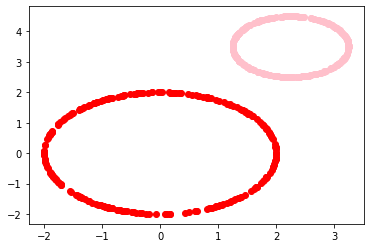

In [313]:
np.random.seed(1)
X_1= tf.convert_to_tensor(np.array(uniform_circle(300,2)).T)
X_2 = tf.convert_to_tensor((np.array(uniform_circle(300,1)).T + [2.25,3.5]))
plt.scatter(X_1[:,0],X_1[:,1],c="red")
plt.scatter(X_2[:,0],X_2[:,1],c="pink")

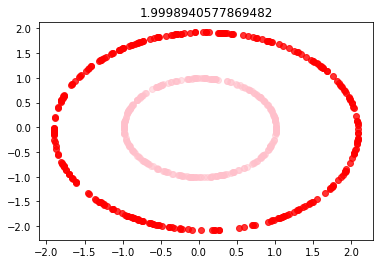

max_scale tf.Tensor(1.9998940577869482, shape=(), dtype=float64)
bestScale 1.9998940577869482


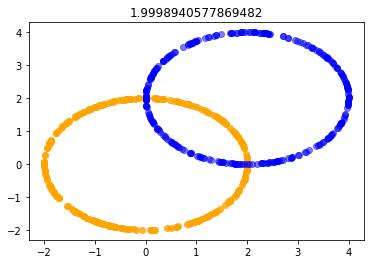

In [316]:
#center PDs only by the x axis 
X_pd = X_1 - tf.math.reduce_mean(X_1,axis=0)
Y_pd = X_2 - tf.math.reduce_mean(X_2,axis=0)

D = X_pd.numpy()
D1 = Y_pd.numpy()
plt.figure()
plt.scatter(D[:,0], D[:,1], c="red", alpha=0.8)
plt.scatter(D1[:,0], D1[:,1],c="pink", alpha=0.5)
plt.title(bestScaleShifts)
plt.show()


#check for issues with numpy vs tensorflow            
scaleshifts, bottleneckDistance, minBottleneckDistance, bestScaleShifts = myScaledDistance(Y_pd, X_pd) #normally 100


shiftedY = bestScaleShifts*(Y_pd)
zeroStart = tf.math.reduce_min(shiftedY,axis=0) #return back to zero
shiftedY = shiftedY - zeroStart

D = X_1.numpy()
D1 = shiftedY.numpy()
plt.figure()
plt.scatter(D[:,0], D[:,1], c="orange", alpha=0.8)
plt.scatter(D1[:,0], D1[:,1],c="blue", alpha=0.5)
plt.title(bestScaleShifts)
plt.show()


# Non-Optimized

In [198]:
start = time.time()
scaleshifts, bottleneckDistance, minBottleneckDistance, bestScaleShifts = myScaledDistance(X_2,X_1,5,15)
end = time.time()
print("Computation Time:", end-start)

Computation Time: 32.24091386795044


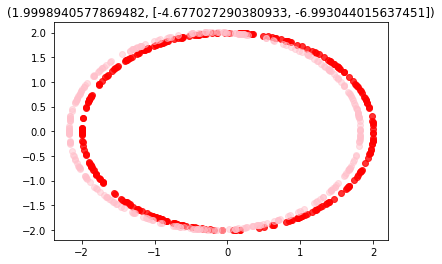

In [199]:
shiftedY = bestScaleShifts[0]*(X_2) +  bestScaleShifts[1]# -0.4591470184829598
D = X_1.numpy()
D1 = shiftedY.numpy()
plt.figure()
plt.scatter(D[:,0], D[:,1], c="red", alpha=0.8)
plt.scatter(D1[:,0], D1[:,1],c="pink", alpha=0.5)
plt.title(bestScaleShifts)
plt.show()

In [214]:
start = time.time()
scaleshifts, bottleneckDistance, minBottleneckDistance, bestScaleShifts = myScaledDistance(X_1,X_2,5,15)
end = time.time()
print("Computation Time:", end-start)

Computation Time: 25.80608820915222


### wasserstein distance isn't perfect

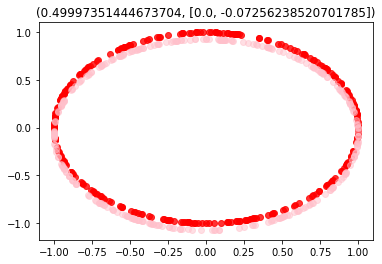

In [218]:
shiftedY = bestScaleShifts[0]*(X_1) +  bestScaleShifts[1]# -0.4591470184829598
D = X_2.numpy()
D1 = shiftedY.numpy()
plt.figure()
plt.scatter(D[:,0], D[:,1], c="red", alpha=0.8)
plt.scatter(D1[:,0], D1[:,1],c="pink", alpha=0.5)
plt.title(bestScaleShifts)
plt.show()

In [219]:
wasserstein_distance(shiftedY.numpy(), X_2.numpy(), order=2, internal_p=2)

1.8535118994329618

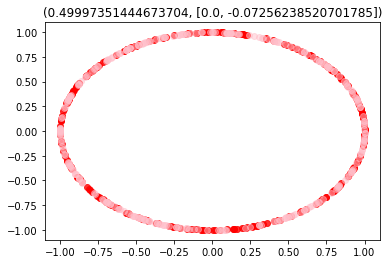

In [220]:
shiftedY = bestScaleShifts[0]*(X_1) + [0,0] #bestScaleShifts[1]
D = X_2.numpy()
D1 = shiftedY.numpy()
plt.figure()
plt.scatter(D[:,0], D[:,1], c="red", alpha=0.8)
plt.scatter(D1[:,0], D1[:,1],c="pink", alpha=0.5)
plt.title(bestScaleShifts)
plt.show()

In [221]:
wasserstein_distance(shiftedY.numpy(), X_2.numpy(), order=2, internal_p=2)

1.9247068690706473

# Optimized

In [91]:
np.random.seed(1)
X_1 = tf.convert_to_tensor(np.array(uniform_circle(300,2)).T)
np.random.seed(1)
X_2 = tf.convert_to_tensor((np.array(uniform_circle(300,1)).T + [2.25,3.5]))

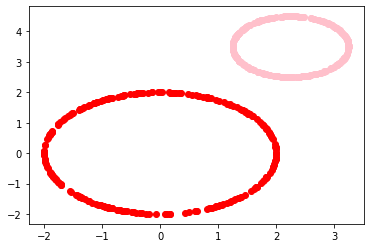

In [92]:
plt.scatter(X_1[:,0],X_1[:,1],c="red")
plt.scatter(X_2[:,0],X_2[:,1],c="pink")

#### right scaling to left

In [201]:
start = time.time()
scaleshifts, bottleneckDistance, minBottleneckDistance, bestScaleShifts = myScaledDistance(X_2,X_1,5,15)
end = time.time()
print("Computation Time:", end-start)

Computation Time: 12.258177995681763


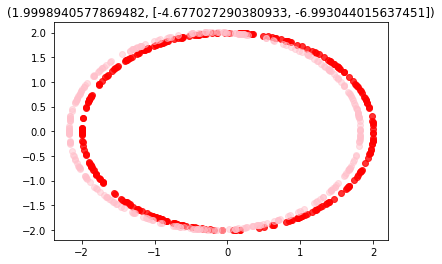

In [202]:
shiftedY = bestScaleShifts[0]*(X_2) +  bestScaleShifts[1]# -0.4591470184829598
D = X_1.numpy()
D1 = shiftedY.numpy()
plt.figure()
plt.scatter(D[:,0], D[:,1], c="red", alpha=0.8)
plt.scatter(D1[:,0], D1[:,1],c="pink", alpha=0.5)
plt.title(bestScaleShifts)
plt.show()

#### left scaling to right

In [204]:
start = time.time()
scaleshifts, bottleneckDistance, minBottleneckDistance, bestScaleShifts = myScaledDistance(X_1,X_2,5,15)
end = time.time()
print("Computation Time:", end-start)

Computation Time: 22.33049488067627


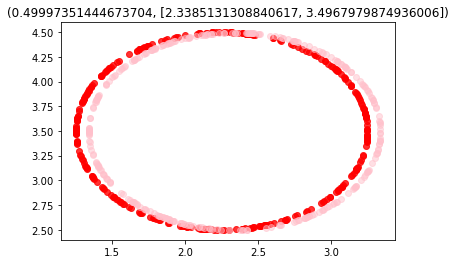

In [208]:
shiftedY = bestScaleShifts[0]*(X_1) +  bestScaleShifts[1]# -0.4591470184829598
D = X_2.numpy()
D1 = shiftedY.numpy()
plt.figure()
plt.scatter(D[:,0], D[:,1], c="red", alpha=0.8)
plt.scatter(D1[:,0], D1[:,1],c="pink", alpha=0.5)
plt.title(bestScaleShifts)
plt.show()

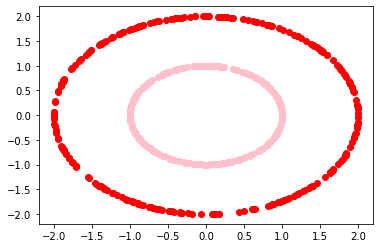

In [209]:
#data

np.random.seed(1)
X_1 = tf.convert_to_tensor(np.array(uniform_circle(300,2)).T)
X_2 = tf.convert_to_tensor((np.array(uniform_circle(300,1)).T))
plt.scatter(X_1[:,0],X_1[:,1],c="red")
plt.scatter(X_2[:,0],X_2[:,1],c="pink")

#### big to small

In [210]:
start = time.time()
scaleshifts, bottleneckDistance, minBottleneckDistance, bestScaleShifts = myScaledDistance(X_1,X_2,5,15)
end = time.time()
print("Computation Time:", end-start)

Computation Time: 14.908480167388916


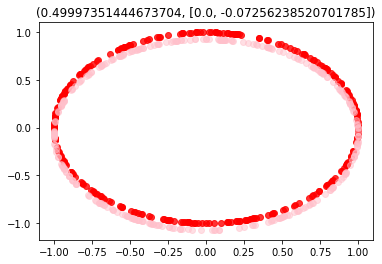

In [211]:
shiftedY = bestScaleShifts[0]*(X_1) +  bestScaleShifts[1]# -0.4591470184829598
D = X_2.numpy()
D1 = shiftedY.numpy()
plt.figure()
plt.scatter(D[:,0], D[:,1], c="red", alpha=0.8)
plt.scatter(D1[:,0], D1[:,1],c="pink", alpha=0.5)
plt.title(bestScaleShifts)
plt.show()

#### small to big

In [223]:
start = time.time()
scaleshifts, bottleneckDistance, minBottleneckDistance, bestScaleShifts = myScaledDistance(X_2,X_1,5,15)
end = time.time()
print("Computation Time:", end-start)

Computation Time: 13.51106595993042


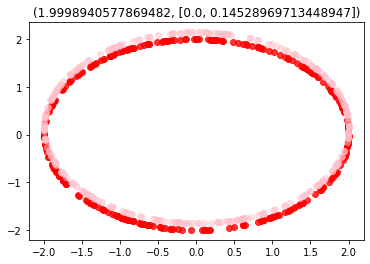

In [224]:
shiftedY = bestScaleShifts[0]*(X_2) +  bestScaleShifts[1]# -0.4591470184829598
D = X_1.numpy()
D1 = shiftedY.numpy()
plt.figure()
plt.scatter(D[:,0], D[:,1], c="red", alpha=0.8)
plt.scatter(D1[:,0], D1[:,1],c="pink", alpha=0.5)
plt.title(bestScaleShifts)
plt.show()

# Verify shift and scale procedure

In [159]:
scaleshifts, bottleneckDistance, minBottleneckDistance, bestScaleShifts = myScaledDistance(X_2,X_1,3,5) #shift pink to red

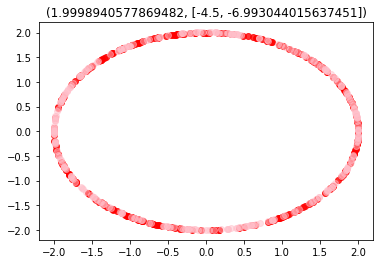

In [160]:
shiftedY = bestScaleShifts[0]*(X_2) +  bestScaleShifts[1]# -0.4591470184829598
D = X_1.numpy()
D1 = shiftedY.numpy()
plt.figure()
plt.scatter(D[:,0], D[:,1], c="red", alpha=0.8)
plt.scatter(D1[:,0], D1[:,1],c="pink", alpha=0.5)
plt.title(bestScaleShifts)
plt.show()

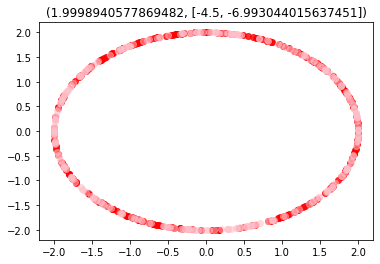

In [156]:
shiftedY = 2*(X_2) +  [-4.5, -7.0]# -0.4591470184829598
D = X_1.numpy()
D1 = shiftedY.numpy()
plt.figure()
plt.scatter(D[:,0], D[:,1], c="red", alpha=0.8)
plt.scatter(D1[:,0], D1[:,1],c="pink", alpha=0.5)
plt.title(bestScaleShifts)
plt.show()

In [154]:
bestScaleShifts

(1.9998940577869482, [-4.5, -6.993044015637451])

# Got close

In [180]:
scaleshifts

[(0.49997351444673704, [-2.2371310382592635, -2.2371310382592635]),
 (0.49997351444673704, [-2.2371310382592635, -1.8429513610210375]),
 (0.49997351444673704, [-1.8429513610210375, -2.2371310382592635]),
 (0.49997351444673704, [-1.8429513610210375, -1.8429513610210375]),
 (0.49997351444673704, [-1.8429513610210375, -1.4487716837828115]),
 (0.9999470288934741, [-4.4866056018579785, -4.4866056018579785]),
 (0.9999470288934741, [-4.07622576418672, -4.4866056018579785]),
 (0.9999470288934741, [-3.6658459265154613, -4.4866056018579785]),
 (0.9999470288934741, [-3.6658459265154613, -4.07622576418672]),
 (0.9999470288934741, [-3.255466088844203, -4.4866056018579785]),
 (0.9999470288934741, [-3.255466088844203, -4.07622576418672]),
 (0.9999470288934741, [-2.845086251172944, -4.4866056018579785]),
 (0.9999470288934741, [-2.845086251172944, -4.07622576418672]),
 (0.9999470288934741, [-2.845086251172944, -3.6658459265154613]),
 (1.4999205433402112, [-7.31997476865582, -7.31997476865582]),
 (1.499

In [126]:
scaleshifts, bottleneckDistance, minBottleneckDistance, bestScaleShifts = myScaledDistance(X_2,X_1,5,10) #shift pink to red

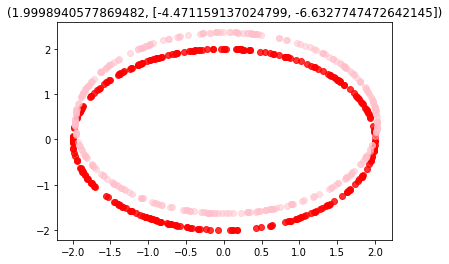

In [127]:
shiftedY = bestScaleShifts[0]*(X_2) +  bestScaleShifts[1]# -0.4591470184829598
D = X_1.numpy()
D1 = shiftedY.numpy()
plt.figure()
plt.scatter(D[:,0], D[:,1], c="red", alpha=0.8)
plt.scatter(D1[:,0], D1[:,1],c="pink", alpha=0.5)
plt.title(bestScaleShifts)
plt.show()

# Debug

In [228]:
def Rips(DX, mel, dim, card):
    # Parameters: DX (distance matrix), 
    #             mel (maximum edge length for Rips filtration), 
    #             dim (homological dimension), 
    #             card (number of persistence diagram points, sorted by distance-to-diagonal)

    # Compute the persistence pairs with Gudhi
    rc = gd.RipsComplex(distance_matrix=DX, max_edge_length=mel)
    st = rc.create_simplex_tree(max_dimension=dim+1)
    dgm = st.persistence()
    pairs = st.persistence_pairs()
    
    #sort by max persistence
    

    # Retrieve vertices v_a and v_b by picking the ones achieving the maximal
    # distance among all pairwise distances between the simplex vertices
    indices, pers = [], []
    
    
    for s1, s2 in pairs:
        if len(s1) == dim+1 and len(s2) > 0:
            l1, l2 = np.array(s1), np.array(s2)
            i1 = [s1[v] for v in np.unravel_index(np.argmax(DX[l1,:][:,l1]),[len(s1), len(s1)])]
            i2 = [s2[v] for v in np.unravel_index(np.argmax(DX[l2,:][:,l2]),[len(s2), len(s2)])]
            indices += i1
            indices += i2
            pers.append(st.filtration(s2) - st.filtration(s1))
    
    # Sort points with distance-to-diagonal
    perm = np.argsort(pers)
    indices = list(np.reshape(indices, [-1,4])[perm][::-1,:].flatten())
    
    # Output indices
    indices = indices[:4*card] + [0 for _ in range(0,max(0,4*card-len(indices)))]
    
    return list(np.array(indices, dtype=np.int32))

class RipsModel(tf.keras.Model):
    def __init__(self, P, X, mel=12, dim=1, card=150):
        super(RipsModel, self).__init__()
        self.P = P
        self.mel = mel
        self.dim = dim
        self.card = card
        self.X = X
        
    # Question: What is the purpose of this function?
    def call(self):
        m, d, c = self.mel, self.dim, self.card
        X = self.X

        #Question: Why are distances being calculcated here? why does gradient keyword show up?

        # Compute distance matrix
        DX = tfa.losses.metric_learning.pairwise_distance(X)
        DXX = tf.reshape(DX, [1, DX.shape[0], DX.shape[1]])
        
        # Turn numpy function into tensorflow function
        XRipsTF = lambda DX: tf.numpy_function(Rips, [DX, m, d, c], [tf.int32 for _ in range(4*c)])
        
        # Compute vertices associated to positive and negative simplices 
        # Don't compute gradient for this operation
        Xids = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(XRipsTF,DXX,dtype=[tf.int32 for _ in range(4*c)]))
        # Get persistence diagram by simply picking the corresponding entries in the distance matrix
        Xdgm = tf.reshape(tf.gather_nd(DX, tf.reshape(Xids, [2*c,2])), [c,2])


        #Z=X@self.P
        Z=self.P
        # Compute distance matrix
        DZ = tfa.losses.metric_learning.pairwise_distance(Z)
        DZZ = tf.reshape(DZ, [1, DZ.shape[0], DZ.shape[1]])
        
        # Turn numpy function into tensorflow function
        ZRipsTF = lambda DZ: tf.numpy_function(Rips, [DZ, m, d, c], [tf.int32 for _ in range(4*c)])
        
        # Compute vertices associated to positive and negative simplices 
        # Don't compute gradient for this operation
        Zids = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(ZRipsTF,DZZ,dtype=[tf.int32 for _ in range(4*c)]))
        # Get persistence diagram by simply picking the corresponding entries in the distance matrix
        Zdgm = tf.reshape(tf.gather_nd(DZ, tf.reshape(Zids, [2*c,2])), [c,2])
        return (Xdgm,Zdgm)

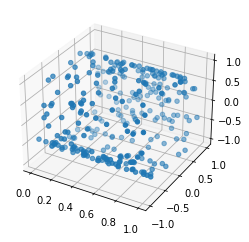

In [229]:
#Data generated on a cylinder with a hole on the wall

np.random.seed(1) #expand the cylinder into a rectangle and generate 300 points on it and then transform them back
ss3=np.random.uniform(0,2*np.pi,300)
noise=np.random.normal(0,0.1,300) #add noise if you want


noise = 0 #to cancel noise
xx=(1+noise)*np.cos(ss3)
yy=(1+noise)*np.sin(ss3)



rr3=np.random.uniform(0,1,300) #a point (xx,yy,rr3) on 3D
ax = plt.subplot(111, projection='3d')
ax.scatter(rr3,xx,yy) 
X=np.array(np.mat([rr3,xx,yy]).T,dtype=np.float32)
Z=X[:,:2]
plt.show()

# With shift

In the example below, it can be seen that when you optimize the shift, the persistence diagrams won't align at 0.

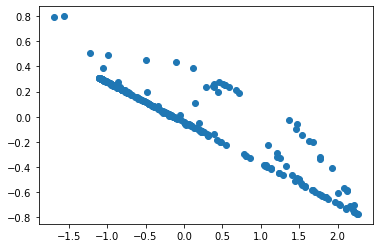

2022-05-30 09:37:39.614564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-30 09:37:40.826752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


type Zdgm <class 'tensorflow.python.framework.ops.EagerTensor'>
type Xdgm <class 'tensorflow.python.framework.ops.EagerTensor'>
y (150, 2)


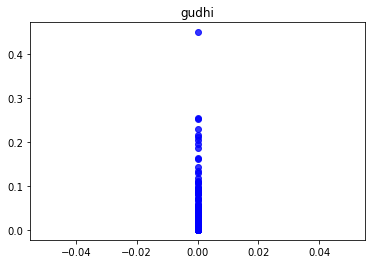

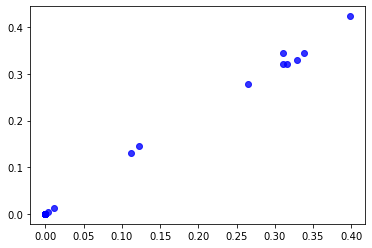

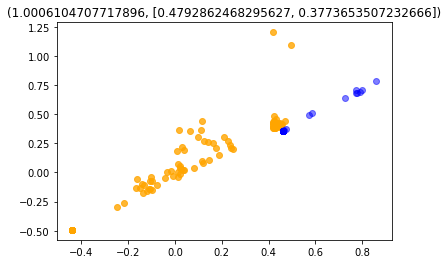

loss tf.Tensor(1.5632827, shape=(), dtype=float32)


2022-05-30 09:37:47.423441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


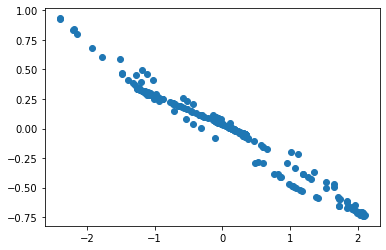

type Zdgm <class 'tensorflow.python.framework.ops.EagerTensor'>
type Xdgm <class 'tensorflow.python.framework.ops.EagerTensor'>
y (150, 2)


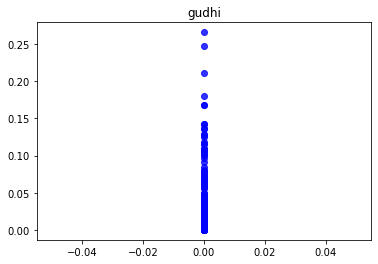

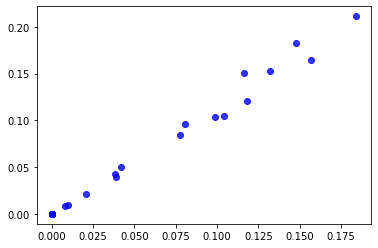

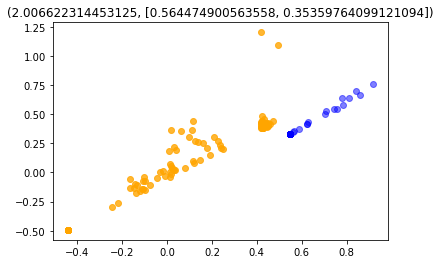

loss tf.Tensor(4.0341473, shape=(), dtype=float32)


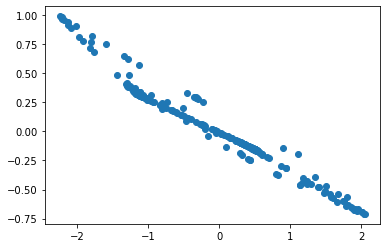

type Zdgm <class 'tensorflow.python.framework.ops.EagerTensor'>
type Xdgm <class 'tensorflow.python.framework.ops.EagerTensor'>
y (150, 2)


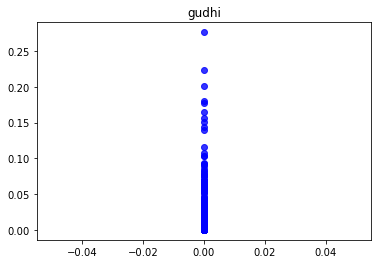

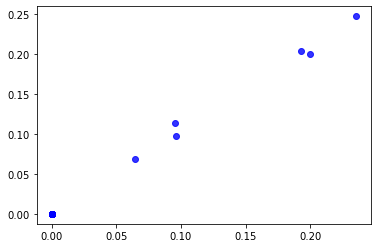

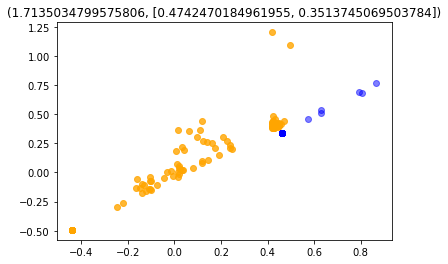

loss tf.Tensor(1.9053414, shape=(), dtype=float32)


In [242]:
tf.random.set_seed(2)
np.random.seed(1)
swiss = make_swiss_roll_with_hole(n_samples = 300)
swiss = np.array(swiss, dtype = np.float32)
X = swiss

lr = 0.1
n_samples = 300
lr_decay = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=lr,
                decay_steps=100000,
                decay_rate=0.96,
                staircase=True)
activation = "sigmoid"
layer = 2
initializer = initializers.GlorotNormal(seed=1)

model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(3, )),
        tf.keras.layers.Dense(3, activation=activation,kernel_initializer=initializer),
        tf.keras.layers.Dense(3, activation=activation,kernel_initializer=initializer),
        tf.keras.layers.Dense(2)
        ])

                
model.compile(loss=shift_inv_dist_center(),optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_decay, name='Adam'),run_eagerly=True)
history = model.fit(X, X,epochs=3,batch_size=n_samples,verbose = 0) 

# With scale, but no shift

As you can see below, the persistence diagrams align at 0.

In [306]:
#only scale, no shift

def myScaledDistance(X, Y, num_partitions=10):
    
    #input: X, and Y are centered persistence diagrams
    
    
    #calculcate range of scale
    
    x0_dist = tf.math.reduce_max(X[:,0]) - tf.math.reduce_min(X[:,0])
    x1_dist = tf.math.reduce_max(X[:,1]) - tf.math.reduce_min(X[:,1])
    x_dist =  tf.math.maximum(x0_dist,x1_dist)
    
    y0_dist = tf.math.reduce_max(Y[:,0]) - tf.math.reduce_min(Y[:,0])
    y1_dist = tf.math.reduce_max(Y[:,1]) - tf.math.reduce_min(Y[:,1])
    y_dist =  tf.math.maximum(y0_dist,y1_dist)
    

    max_scale = tf.math.maximum(x_dist/y_dist,y_dist/x_dist)
    
    #for infinity error
    if tf.math.is_inf(max_scale):
        max_scale = y_dist
    
    print("max_scale",max_scale)
    
    ## character point
#     indX = np.argmax(X[:,1]-X[:,0]) 
#     indY = np.argmax(Y[:,1]-Y[:,0])
#     chaX = X[indX,:]
#     chaY = Y[indY,:]
    
#     ## define the searching interval
#     B = 1e3 ## translation parameter. This is a bug in gudhi that they donot accept negative inputs
#     oriDist = gd.bottleneck_distance(X+B,Y+B)
# #    print("original bottleneck distance", oriDist)
#     upBound = max(Y[:,1])-chaX[1]+oriDist
#     lowBound = chaY[1]-max(X[:,1])-oriDist
    
    ## define shifts
    scales = np.linspace(0, max_scale, num_partitions)
    scaleInv = scales[1:] #remove 0
    bottleneckDistance = []
    
    #calculcate shifts required to move PDS to first quadrant
    shift0 = tf.math.abs(tf.math.minimum(tf.math.reduce_min(X[:,0]),tf.math.reduce_min(Y[:,0])))
    shift1 = tf.math.abs(tf.math.minimum(tf.math.reduce_min(X[:,1]),tf.math.reduce_min(Y[:,1])))
    shift01 = [shift0,shift1]
    
    
    
    ## scale 0,0 centered PDS, then shift to first quadrant to calculcate bottleneck dist
    #compute bottleneck distance
    for scale in scaleInv:
        scaleX = scale*X  
        firstquad = tf.math.multiply(shift01,scale)
        dist = gd.bottleneck_distance(scaleX+firstquad, Y+firstquad) #bottleneck cannot work wth negative distances
        bottleneckDistance.append(dist)
        

    minBottleneckDistance = min(bottleneckDistance)
    bestScale = scaleInv[np.array(bottleneckDistance).argmin()]
    bestScale = bestScale.item()
    
    print("bestScale",bestScale)

#    print("dilation-invariant bottleneck distance (using log) is", minBottleneckDistance)
    
    return scaleInv, bottleneckDistance, minBottleneckDistance, bestScale

In [303]:
class scale_inv_dist_center(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, Xnn, Ynn):

        
        X = scale(tf.identity(Xnn))
        Y = scale(tf.identity(Ynn))
        
        
        fig, ax = plt.subplots()
        
        #plots the 2d projection
        ax.scatter(Y.numpy()[:,0],Y.numpy()[:,1])
        plt.show()
        
        
#         st = gd.RipsComplex(points = Y, 
#                     max_edge_length = 12).create_simplex_tree(max_dimension=2)
#         st.persistence() #computes persistence intervals

#         #extract persistence intervals for specified dim
#         pd_Y = np.array(st.persistence_intervals_in_dimension(0), dtype=np.float32) #original data
        
        
#         plt.figure()
#         plt.scatter(pd_Y[:,0], pd_Y[:,1], c="blue", alpha=0.8)
#         plt.title("gudhi")

        
        
        #zhaoyang's 
        modelR = RipsModel(P=Y, X=X, mel=12, dim=1, card = 150) #Y.numpy()
        
        
        #Compute persistence diagram
        Zdgm = modelR.call()[1]
        Y_pd_original = Zdgm #.numpy() 
        

        Xdgm = modelR.call()[0]
        X_pd_original = Xdgm #.numpy()
        
        
        #shifting the data so its >=0 so we can take the log 

#         X_pd += 0.1 #tf.math.abs(tf.math.reduce_min(X_pd)) #ASK PROFS ABOUT THIS 0.1 shift okay?
#         Y_pd += 0.1 #tf.math.abs(tf.math.reduce_min(Y_pd)) 

#         X_pd = tf.math.log(X_pd) 
#         Y_pd = tf.math.log(Y_pd)
        

        
#         D = X_pd_original.numpy()
#         D1 = Y_pd_original.numpy()
#         plt.figure()
#         plt.scatter(D[:,0], D[:,1], c="orange", alpha=0.8)
#         plt.scatter(D1[:,0], D1[:,1],c="blue", alpha=0.5)
#         plt.title("before centering")
#         plt.show()
        
        
        #center PDs only by the x axis 
        X_pd = X_pd_original - tf.math.reduce_mean(X_pd_original,axis=0)
        Y_pd = Y_pd_original - tf.math.reduce_mean(Y_pd_original,axis=0)
        
#         D = X_pd.numpy()
#         D1 = Y_pd.numpy()
#         plt.figure()
#         plt.scatter(D[:,0], D[:,1], c="orange", alpha=0.8)
#         plt.scatter(D1[:,0], D1[:,1],c="blue", alpha=0.5)
#         plt.title("centered PDS")
#         plt.show()
        
        

        
        #check for issues with numpy vs tensorflow            
        scaleshifts, bottleneckDistance, minBottleneckDistance, bestScaleShifts = myScaledDistance(Y_pd, X_pd) #normally 100
        
        
        shiftedY = bestScaleShifts*(Y_pd)
        zeroStart = tf.math.reduce_min(shiftedY,axis=0) #return back to zero
        shiftedY = shiftedY - zeroStart

        D = X_pd_original.numpy()
        D1 = shiftedY.numpy()
        plt.figure()
        plt.scatter(D[:,0], D[:,1], c="orange", alpha=0.8)
        plt.scatter(D1[:,0], D1[:,1],c="blue", alpha=0.5)
        plt.title(bestScaleShifts)
        plt.show()
        

        # Loss is Wasserstein distance
        loss = tf.square(wasserstein_distance(shiftedY, X_pd, order=2, internal_p=2, enable_autodiff=True))
        
        print("loss",loss)

        return loss

### converges to line and fails

#Note: A common issue that we had is the projection converging to a line.

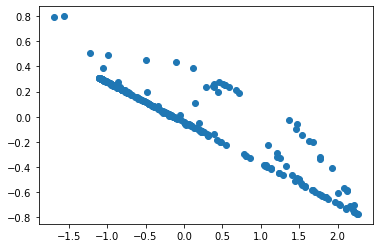

2022-05-30 10:39:13.319579: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-30 10:39:14.631685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


max_scale tf.Tensor(4.002442, shape=(), dtype=float32)
bestScale 2.668294588724772


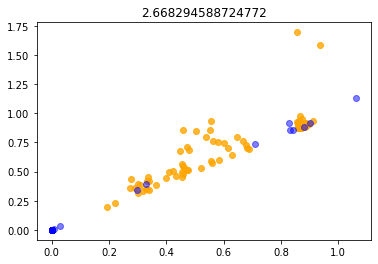

loss tf.Tensor(0.81643283, shape=(), dtype=float32)


2022-05-30 10:39:18.255813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


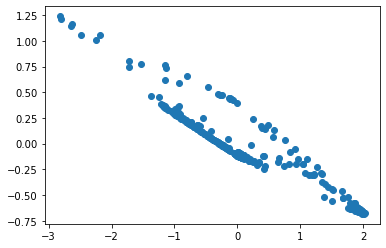

max_scale tf.Tensor(3.779245, shape=(), dtype=float32)
bestScale 3.3593287997775607


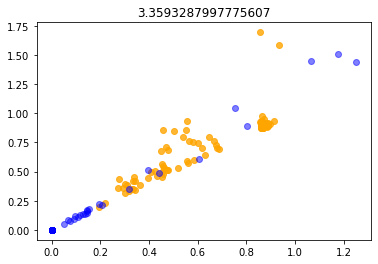

loss tf.Tensor(0.7952666, shape=(), dtype=float32)


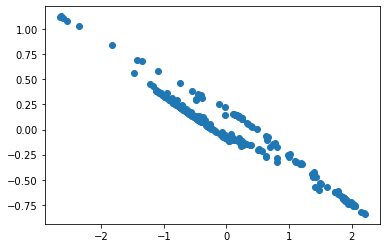

max_scale tf.Tensor(6.4345245, shape=(), dtype=float32)
bestScale 4.289683024088542


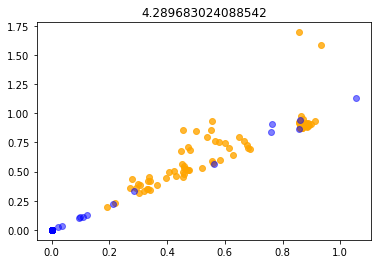

loss tf.Tensor(0.73466426, shape=(), dtype=float32)


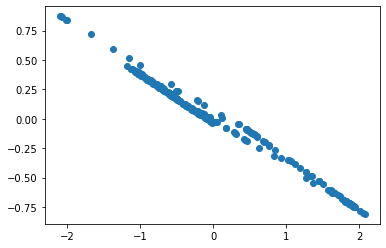

max_scale tf.Tensor(12.175236, shape=(), dtype=float32)
bestScale 9.469627804226345


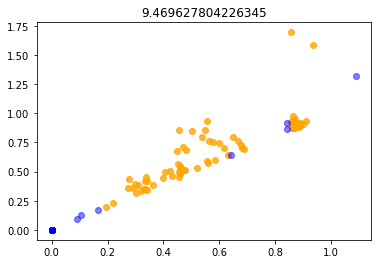

loss tf.Tensor(0.857921, shape=(), dtype=float32)


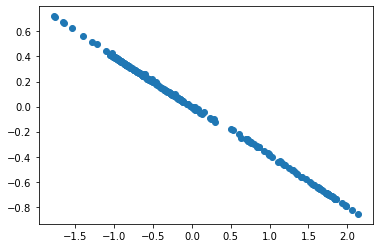

max_scale tf.Tensor(71.979034, shape=(), dtype=float32)
bestScale 7.997670491536458


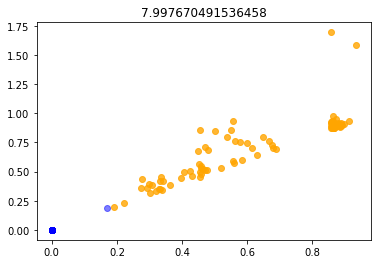

loss tf.Tensor(0.8849797, shape=(), dtype=float32)


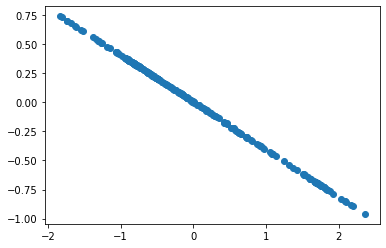

max_scale tf.Tensor(1.6954991, shape=(), dtype=float32)
bestScale 0.18838878472646078


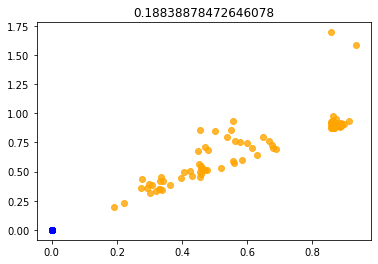

loss tf.Tensor(0.8911998, shape=(), dtype=float32)


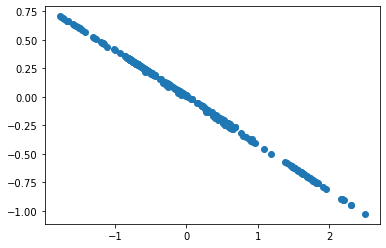

max_scale tf.Tensor(55.38822, shape=(), dtype=float32)
bestScale 6.1542468600802955


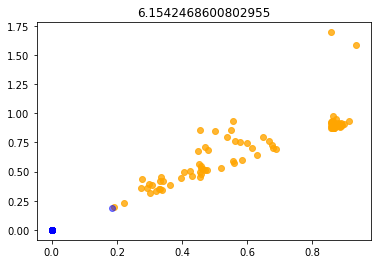

loss tf.Tensor(0.89047825, shape=(), dtype=float32)


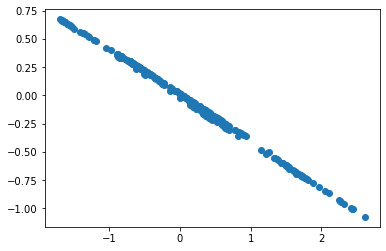

max_scale tf.Tensor(27.928938, shape=(), dtype=float32)
bestScale 15.516076617770725


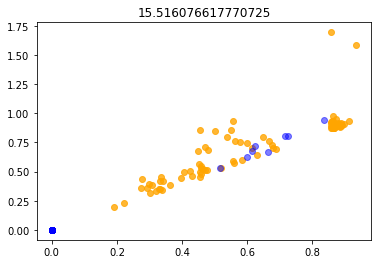

loss tf.Tensor(0.7905815, shape=(), dtype=float32)


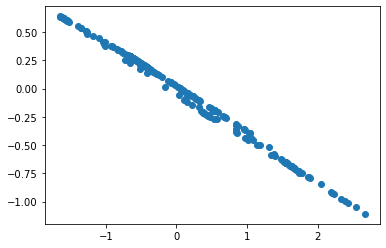

max_scale tf.Tensor(20.202879, shape=(), dtype=float32)
bestScale 11.223821640014648


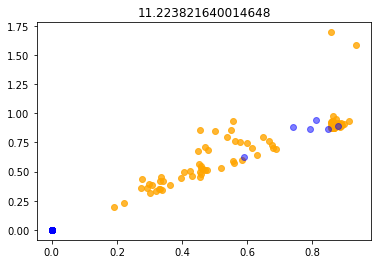

loss tf.Tensor(0.7358194, shape=(), dtype=float32)


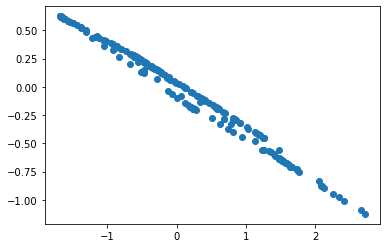

max_scale tf.Tensor(12.425758, shape=(), dtype=float32)
bestScale 6.903199089898004


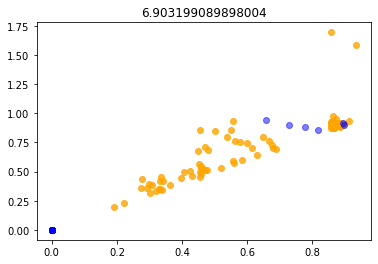

loss tf.Tensor(0.62958014, shape=(), dtype=float32)


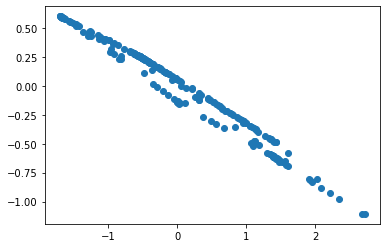

max_scale tf.Tensor(9.527583, shape=(), dtype=float32)
bestScale 6.351722081502279


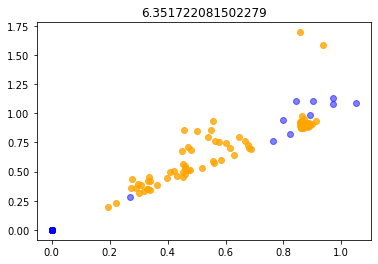

loss tf.Tensor(0.75043416, shape=(), dtype=float32)


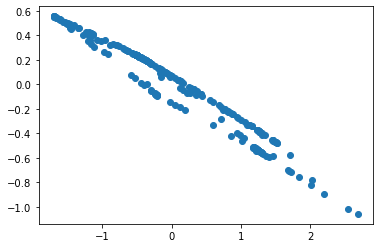

max_scale tf.Tensor(7.0164742, shape=(), dtype=float32)
bestScale 4.67764949798584


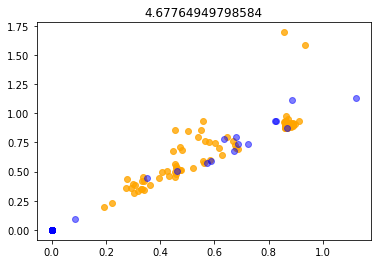

loss tf.Tensor(0.77322006, shape=(), dtype=float32)


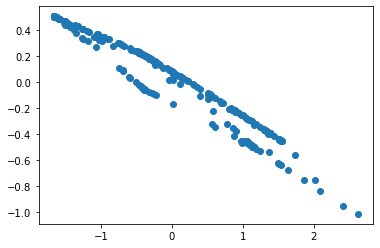

max_scale tf.Tensor(6.932925, shape=(), dtype=float32)
bestScale 5.392275174458822


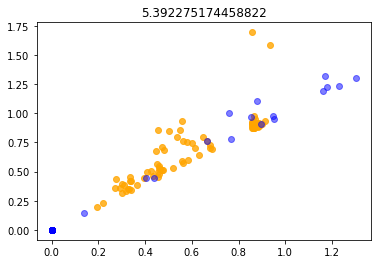

loss tf.Tensor(0.72611773, shape=(), dtype=float32)


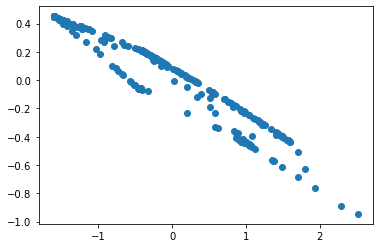

max_scale tf.Tensor(6.410787, shape=(), dtype=float32)
bestScale 3.5615483919779463


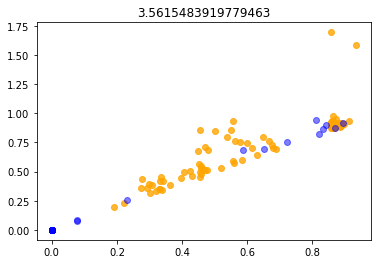

loss tf.Tensor(0.78653157, shape=(), dtype=float32)


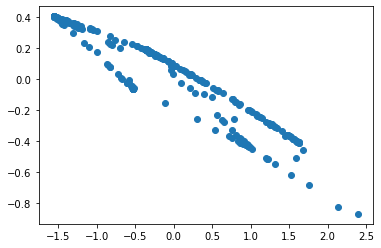

max_scale tf.Tensor(6.6531963, shape=(), dtype=float32)
bestScale 5.174708260430229


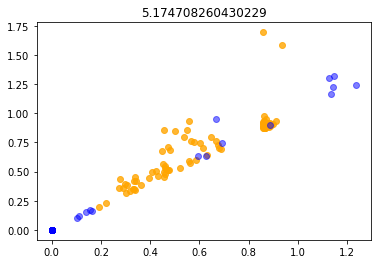

loss tf.Tensor(0.72075766, shape=(), dtype=float32)


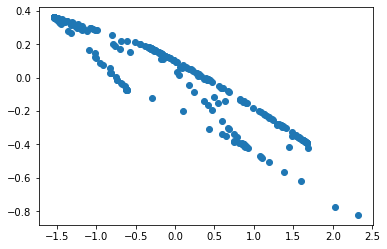

max_scale tf.Tensor(4.8839474, shape=(), dtype=float32)
bestScale 3.798625734117296


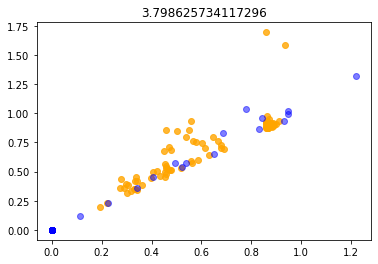

loss tf.Tensor(0.6860714, shape=(), dtype=float32)


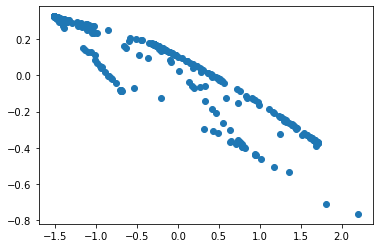

max_scale tf.Tensor(5.669908, shape=(), dtype=float32)
bestScale 3.7799386978149414


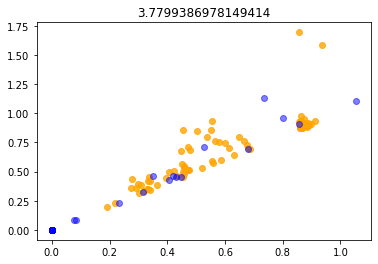

loss tf.Tensor(0.64084315, shape=(), dtype=float32)


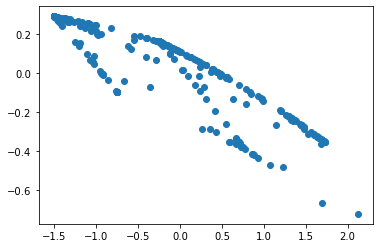

max_scale tf.Tensor(5.666437, shape=(), dtype=float32)
bestScale 3.1480206383599176


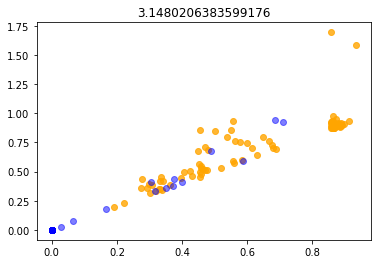

loss tf.Tensor(0.61903805, shape=(), dtype=float32)


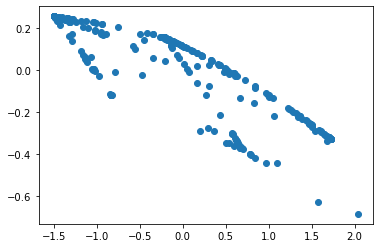

max_scale tf.Tensor(5.732287, shape=(), dtype=float32)
bestScale 3.184603850046794


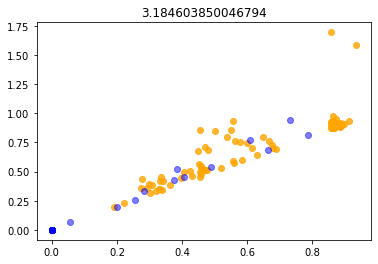

loss tf.Tensor(0.68013924, shape=(), dtype=float32)


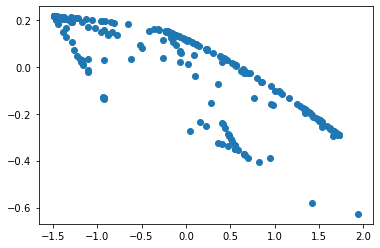

max_scale tf.Tensor(5.4118643, shape=(), dtype=float32)
bestScale 3.0065912670559354


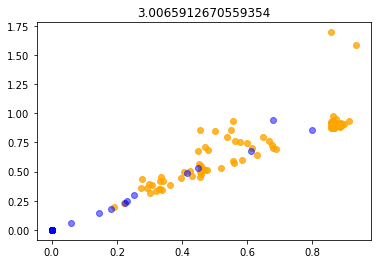

loss tf.Tensor(0.6715854, shape=(), dtype=float32)


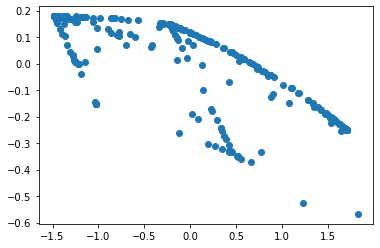

max_scale tf.Tensor(4.530943, shape=(), dtype=float32)
bestScale 3.5240667131212025


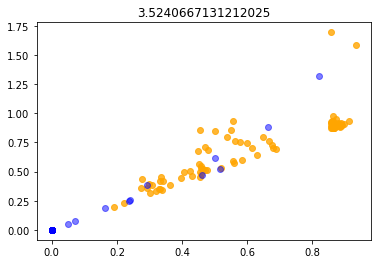

loss tf.Tensor(0.6303872, shape=(), dtype=float32)


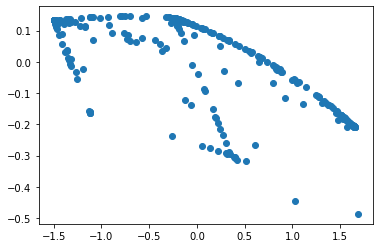

max_scale tf.Tensor(8.08576, shape=(), dtype=float32)
bestScale 4.492088953653972


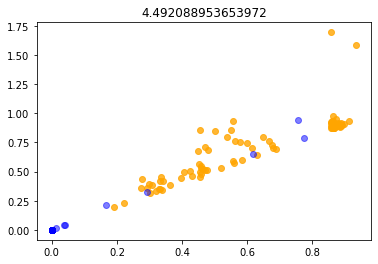

loss tf.Tensor(0.73329204, shape=(), dtype=float32)


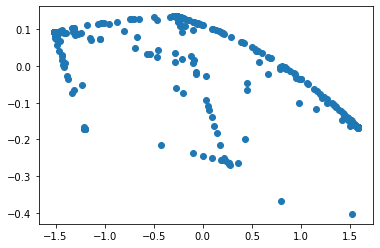

max_scale tf.Tensor(5.494377, shape=(), dtype=float32)
bestScale 4.273404439290365


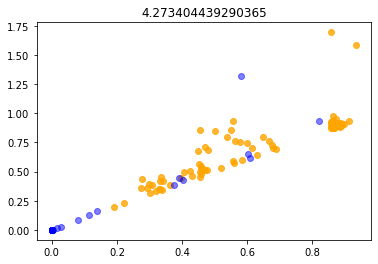

loss tf.Tensor(0.56904215, shape=(), dtype=float32)


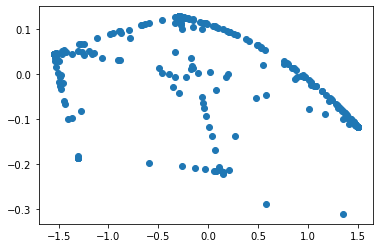

max_scale tf.Tensor(7.1605687, shape=(), dtype=float32)
bestScale 4.773712476094564


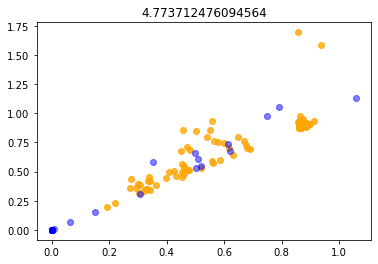

loss tf.Tensor(0.6843676, shape=(), dtype=float32)


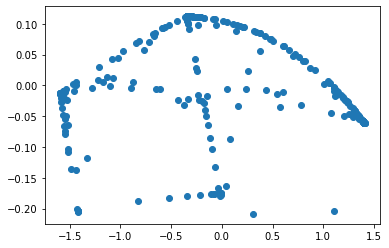

max_scale tf.Tensor(8.834784, shape=(), dtype=float32)
bestScale 4.908213085598415


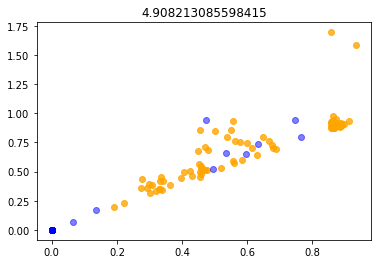

loss tf.Tensor(0.5660524, shape=(), dtype=float32)


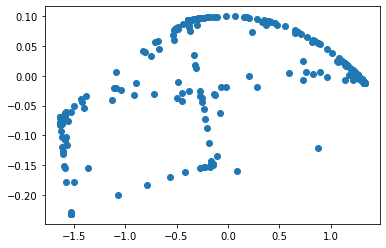

max_scale tf.Tensor(7.416049, shape=(), dtype=float32)
bestScale 6.592043558756511


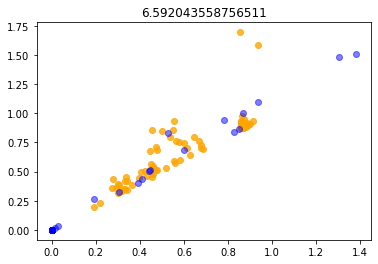

loss tf.Tensor(0.6869152, shape=(), dtype=float32)


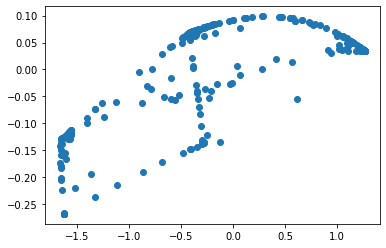

max_scale tf.Tensor(6.000585, shape=(), dtype=float32)
bestScale 6.000585079193115


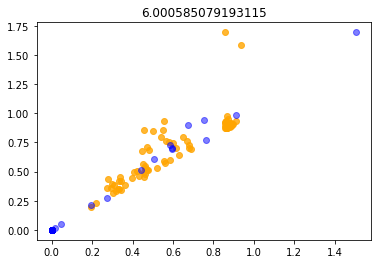

loss tf.Tensor(0.6860114, shape=(), dtype=float32)


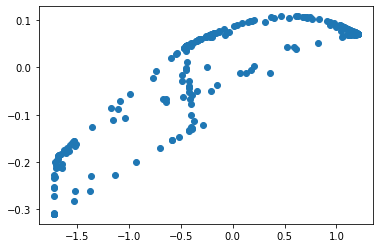

max_scale tf.Tensor(6.9131875, shape=(), dtype=float32)
bestScale 6.913187503814697


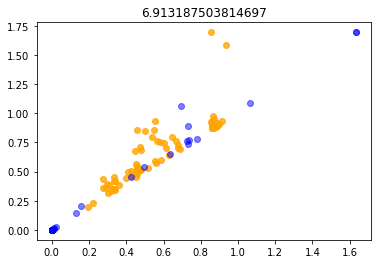

loss tf.Tensor(0.5867808, shape=(), dtype=float32)


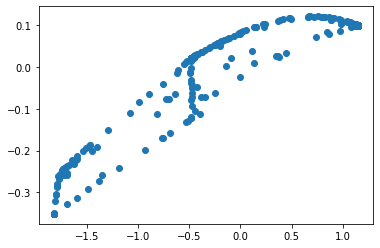

max_scale tf.Tensor(12.042173, shape=(), dtype=float32)
bestScale 9.366134855482315


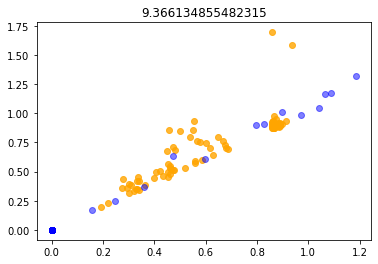

loss tf.Tensor(0.8189307, shape=(), dtype=float32)


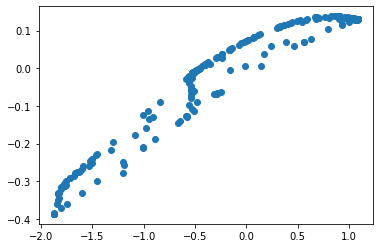

max_scale tf.Tensor(17.125679, shape=(), dtype=float32)
bestScale 13.319972568088108


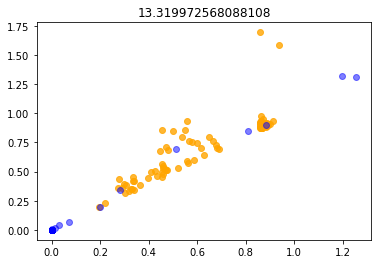

loss tf.Tensor(0.82037646, shape=(), dtype=float32)


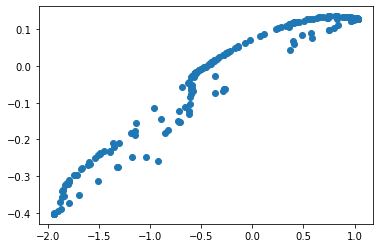

max_scale tf.Tensor(17.312103, shape=(), dtype=float32)
bestScale 11.541402180989584


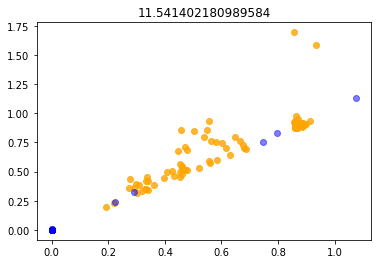

loss tf.Tensor(0.85216653, shape=(), dtype=float32)


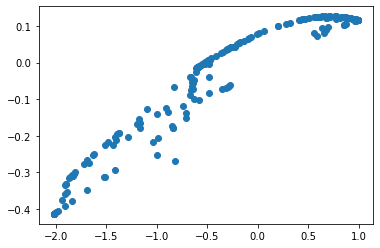

max_scale tf.Tensor(15.9772415, shape=(), dtype=float32)
bestScale 1.77524905734592


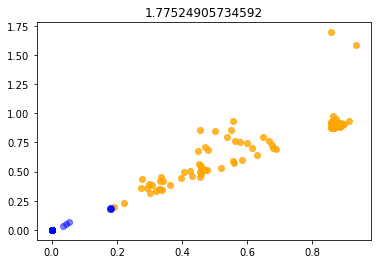

loss tf.Tensor(0.88711995, shape=(), dtype=float32)


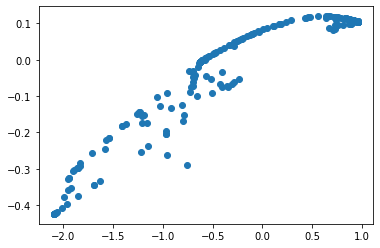

max_scale tf.Tensor(15.305917, shape=(), dtype=float32)
bestScale 8.503287103441027


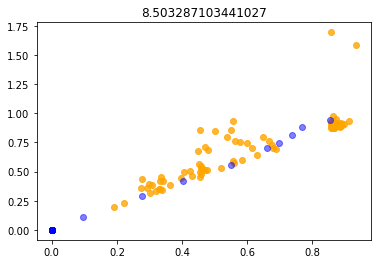

loss tf.Tensor(0.7627878, shape=(), dtype=float32)


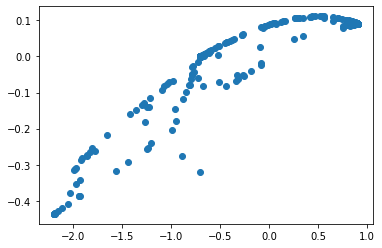

max_scale tf.Tensor(6.5518227, shape=(), dtype=float32)
bestScale 6.551822662353516


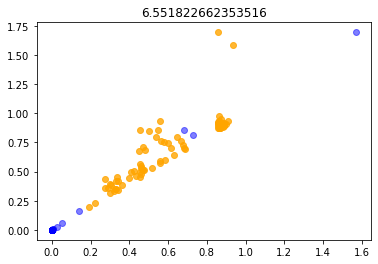

loss tf.Tensor(0.7302221, shape=(), dtype=float32)


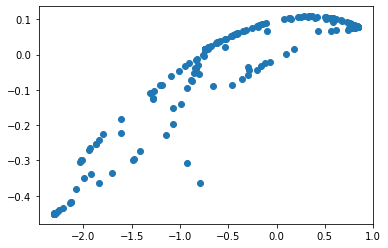

max_scale tf.Tensor(9.002682, shape=(), dtype=float32)
bestScale 7.002085791693794


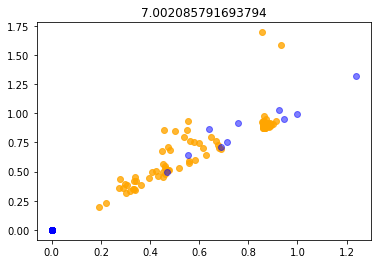

loss tf.Tensor(0.68066657, shape=(), dtype=float32)


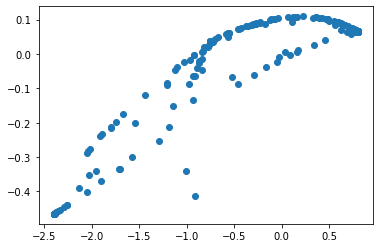

max_scale tf.Tensor(7.137662, shape=(), dtype=float32)
bestScale 5.551514837476942


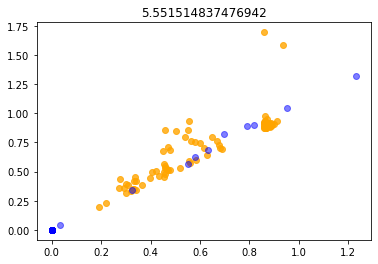

loss tf.Tensor(0.76709604, shape=(), dtype=float32)


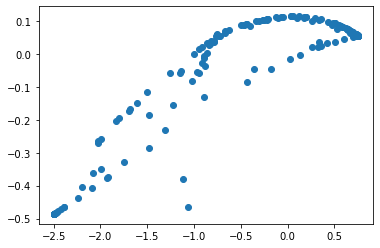

max_scale tf.Tensor(8.794308, shape=(), dtype=float32)
bestScale 8.794307708740234


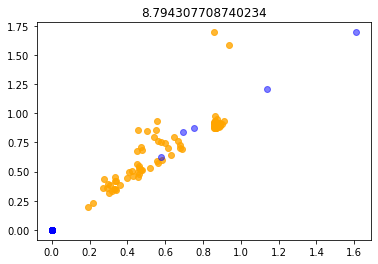

loss tf.Tensor(0.7339155, shape=(), dtype=float32)


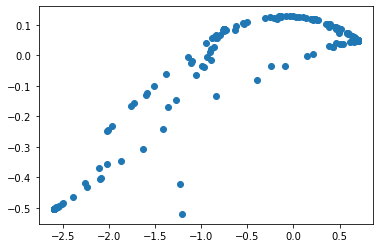

max_scale tf.Tensor(9.509577, shape=(), dtype=float32)
bestScale 1.056619644165039


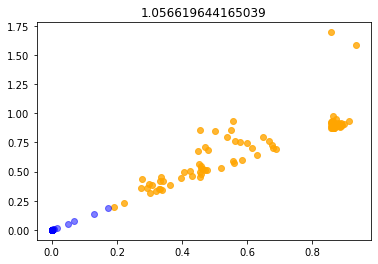

loss tf.Tensor(0.88414735, shape=(), dtype=float32)


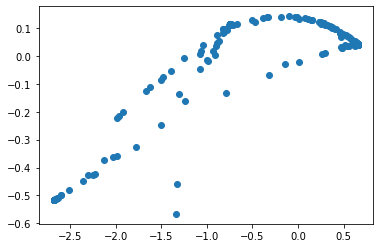

max_scale tf.Tensor(6.9940124, shape=(), dtype=float32)
bestScale 3.8855624198913574


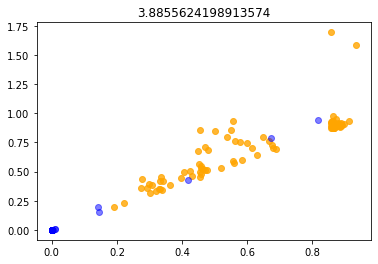

loss tf.Tensor(0.74217224, shape=(), dtype=float32)


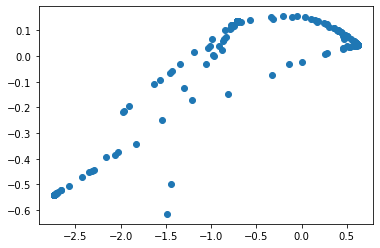

max_scale tf.Tensor(6.7395625, shape=(), dtype=float32)
bestScale 3.744201395246718


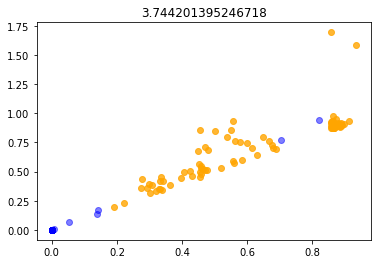

loss tf.Tensor(0.77427423, shape=(), dtype=float32)


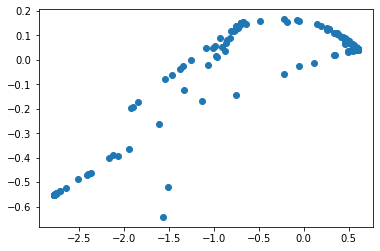

max_scale tf.Tensor(7.215442, shape=(), dtype=float32)
bestScale 4.008578989240858


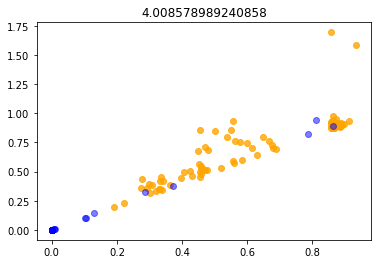

loss tf.Tensor(0.7716683, shape=(), dtype=float32)


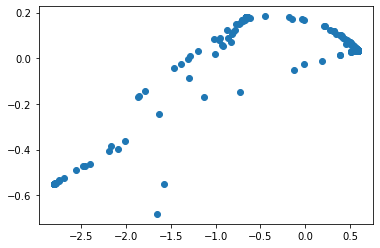

max_scale tf.Tensor(6.286262, shape=(), dtype=float32)
bestScale 3.492367797427707


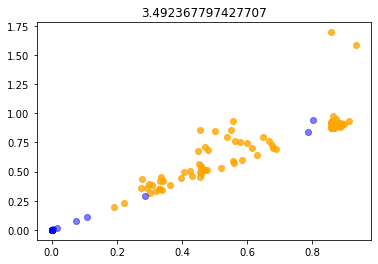

loss tf.Tensor(0.76834315, shape=(), dtype=float32)


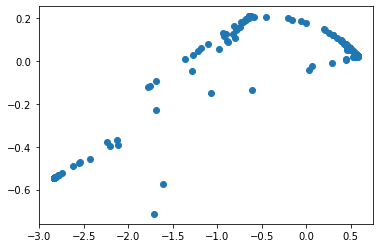

max_scale tf.Tensor(117.9623, shape=(), dtype=float32)
bestScale 13.106922573513454


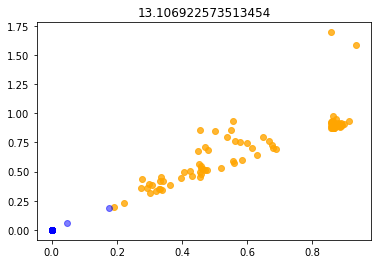

loss tf.Tensor(0.8866361, shape=(), dtype=float32)


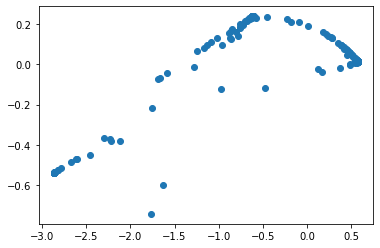

max_scale tf.Tensor(3.2272658, shape=(), dtype=float32)
bestScale 0.3585850927564833


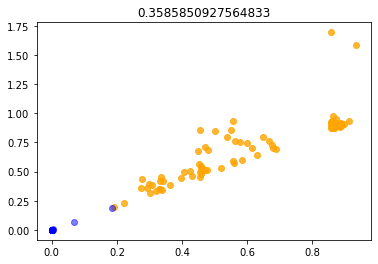

loss tf.Tensor(0.8896368, shape=(), dtype=float32)


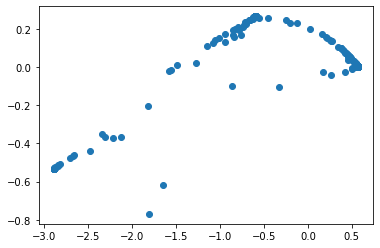

max_scale tf.Tensor(3.1838925, shape=(), dtype=float32)
bestScale 0.3537658320532905


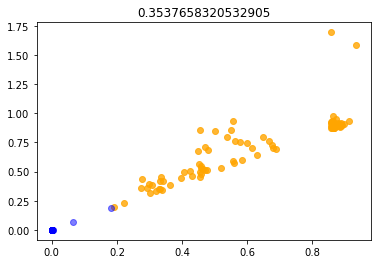

loss tf.Tensor(0.88856727, shape=(), dtype=float32)


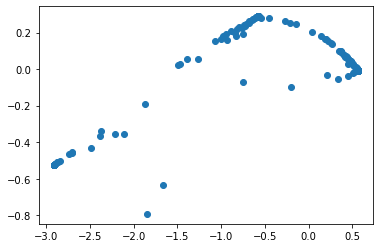

max_scale tf.Tensor(3.2000651, shape=(), dtype=float32)
bestScale 0.35556279288397896


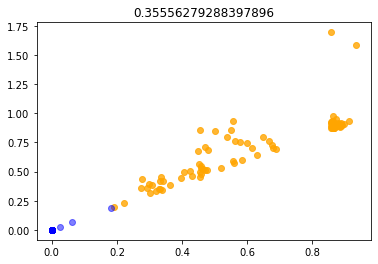

loss tf.Tensor(0.8891761, shape=(), dtype=float32)


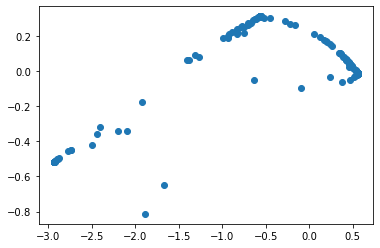

max_scale tf.Tensor(20.78749, shape=(), dtype=float32)
bestScale 2.309721204969618


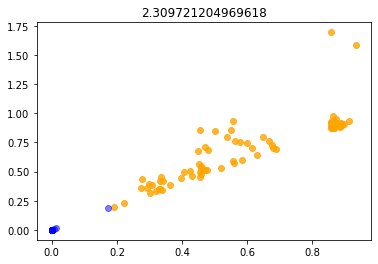

loss tf.Tensor(0.88562167, shape=(), dtype=float32)


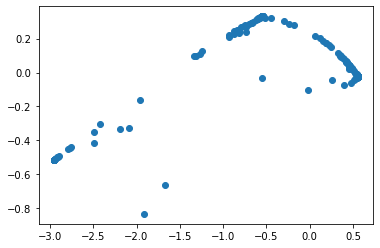

max_scale tf.Tensor(9.651278, shape=(), dtype=float32)
bestScale 1.0723641713460286


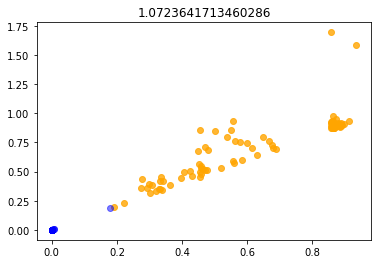

loss tf.Tensor(0.8882994, shape=(), dtype=float32)


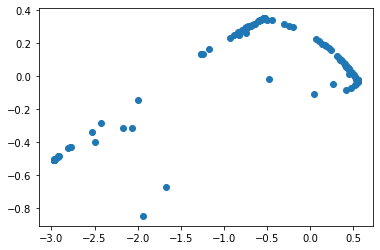

max_scale tf.Tensor(9.762862, shape=(), dtype=float32)
bestScale 1.0847624672783747


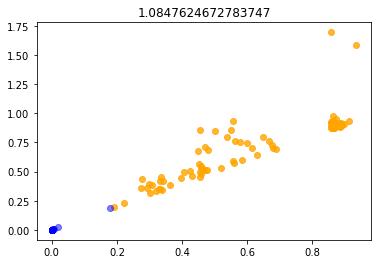

loss tf.Tensor(0.8878252, shape=(), dtype=float32)


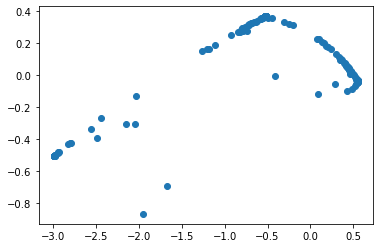

max_scale tf.Tensor(3.292966, shape=(), dtype=float32)
bestScale 0.36588509877522785


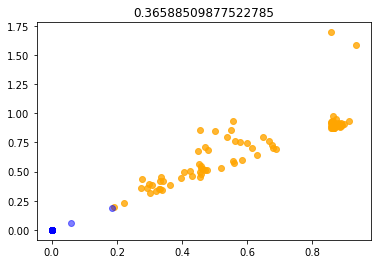

loss tf.Tensor(0.8902002, shape=(), dtype=float32)


In [308]:
#Note: this is a random seed so that the training is reproducible
tf.random.set_seed(2)

np.random.seed(1)
swiss = make_swiss_roll_with_hole(n_samples = 300)
swiss = np.array(swiss, dtype = np.float32)
X = swiss

lr = 0.1
n_samples = 300
lr_decay = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=lr,
                decay_steps=100000,
                decay_rate=0.96,
                staircase=True)
activation = "sigmoid"
layer = 2
initializer = initializers.GlorotNormal(seed=1)

model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(3, )),
        tf.keras.layers.Dense(3, activation=activation,kernel_initializer=initializer),
        tf.keras.layers.Dense(3, activation=activation,kernel_initializer=initializer),
        tf.keras.layers.Dense(2)
        ])

                
model.compile(loss=scale_inv_dist_center(),optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_decay, name='Adam'),run_eagerly=True)
history = model.fit(X, X,epochs=50,batch_size=n_samples,verbose = 0) 

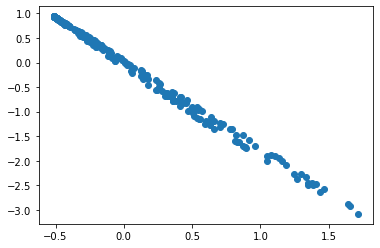

2022-05-30 10:29:33.459616: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-30 10:29:34.684231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


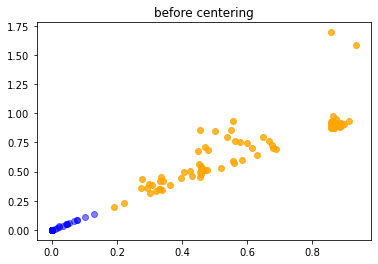

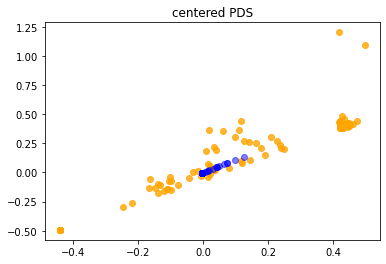

max_scale tf.Tensor(12.637293, shape=(), dtype=float32)
bestScale 11.233149210611979


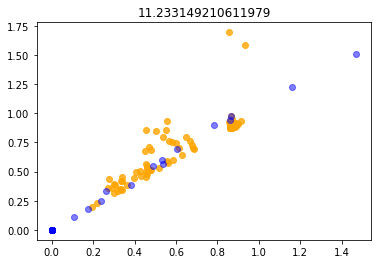

loss tf.Tensor(0.7637118, shape=(), dtype=float32)


2022-05-30 10:29:38.438361: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [301]:
tf.random.set_seed(1)
np.random.seed(1)
swiss = make_swiss_roll_with_hole(n_samples = 300)
swiss = np.array(swiss, dtype = np.float32)
X = swiss

lr = 0.1
n_samples = 300
lr_decay = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=lr,
                decay_steps=100000,
                decay_rate=0.96,
                staircase=True)
activation = "sigmoid"
layer = 2
initializer = initializers.GlorotNormal(seed=1)

model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(3, )),
        tf.keras.layers.Dense(3, activation=activation,kernel_initializer=initializer),
        tf.keras.layers.Dense(3, activation=activation,kernel_initializer=initializer),
        tf.keras.layers.Dense(2)
        ])

                
model.compile(loss=scale_inv_dist_center(),optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_decay, name='Adam'),run_eagerly=True)
history = model.fit(X, X,epochs=1,batch_size=n_samples,verbose = 0) 

### Data & its persistence diagram

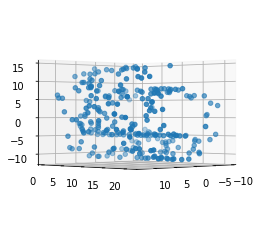

In [7]:
np.random.seed(1)
swiss = make_swiss_roll_with_hole(n_samples = 300)
swiss = np.array(swiss, dtype = np.float32)
plot(swiss)
#swiss += np.abs(swiss.min())


2022-05-13 11:15:45.590144: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-13 11:15:45.590589: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-05-13 11:15:45.703705: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-13 11:15:45.704346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Metal device set to: Apple M1 Pro


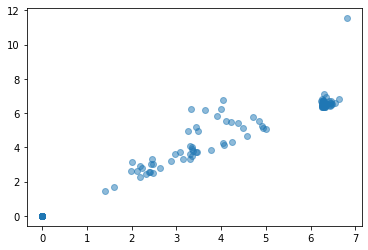

In [10]:
PD(swiss)

##### Verification: Scaling by a factor yeilds same PD

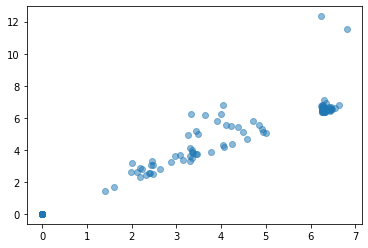

In [32]:
PD(X)

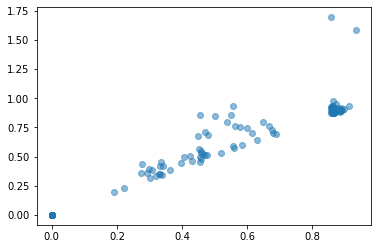

In [33]:
PD(scale(X))

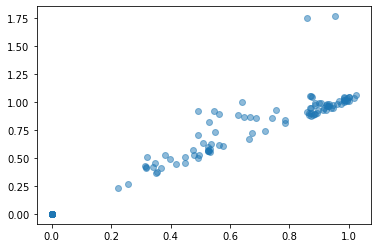

In [35]:
#Normalizing does change the persistence diagram
PD(normalize(X))

# Parameter Tuning

2022-05-02 16:55:36.485497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


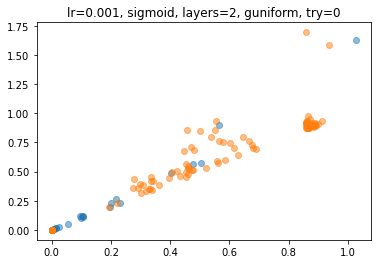

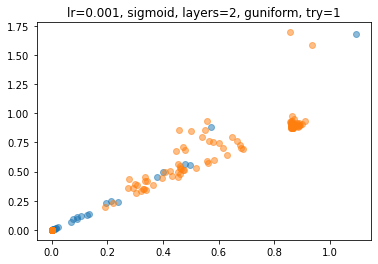

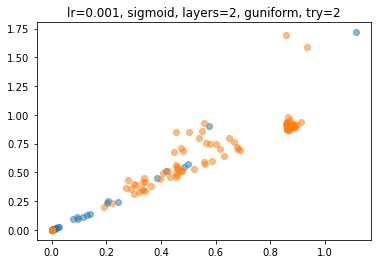

lr=0.001, sigmoid, layers=2, guniform
Final Average Loss:  1.0943684975306194
Iteration Execution Time (min) 15.31569550037384


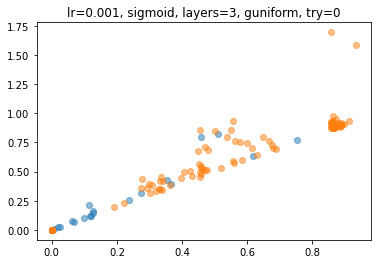

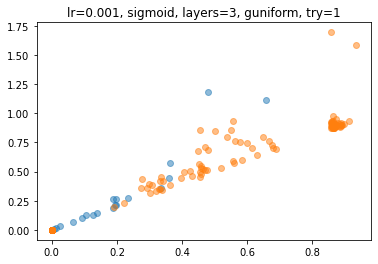

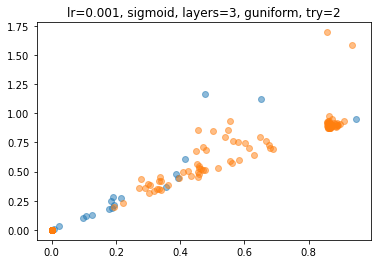

lr=0.001, sigmoid, layers=3, guniform
Final Average Loss:  0.8382233182589213
Iteration Execution Time (min) 13.37071698109309


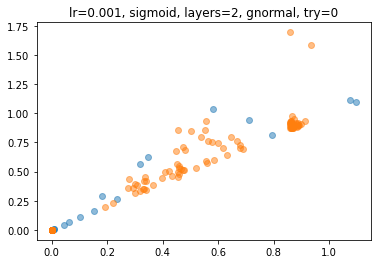

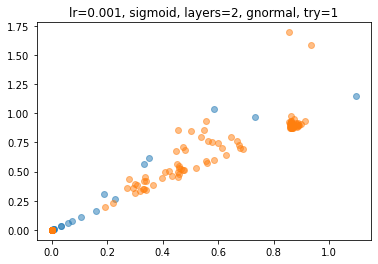

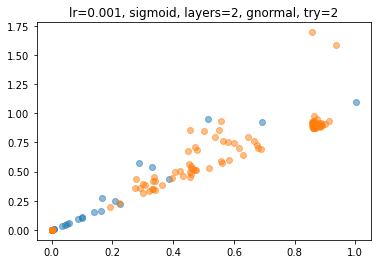

lr=0.001, sigmoid, layers=2, gnormal
Final Average Loss:  0.8443881670633951
Iteration Execution Time (min) 13.351445702711741


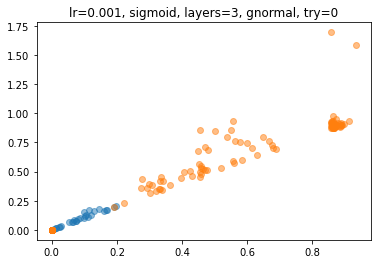

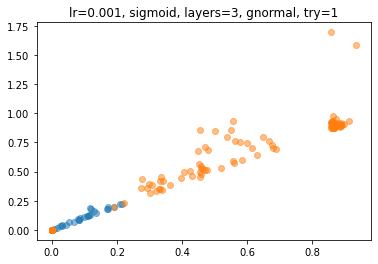

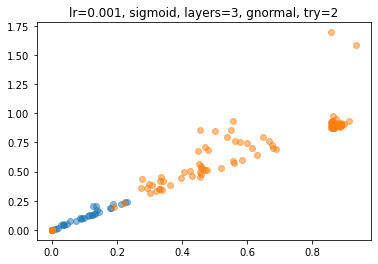

lr=0.001, sigmoid, layers=3, gnormal
Final Average Loss:  1.0818709135055542
Iteration Execution Time (min) 12.593200401465099


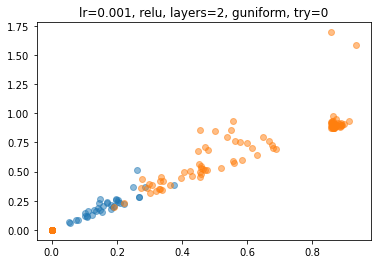

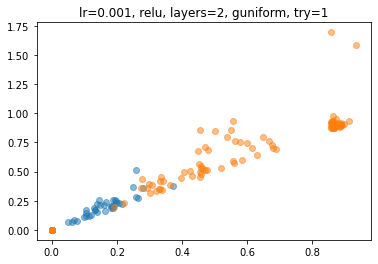

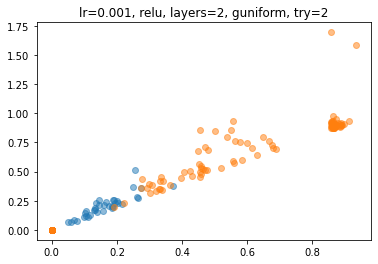

lr=0.001, relu, layers=2, guniform
Final Average Loss:  0.6514168381690979
Iteration Execution Time (min) 12.682169433434805


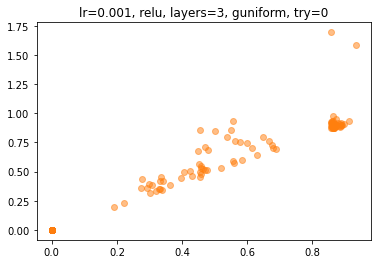

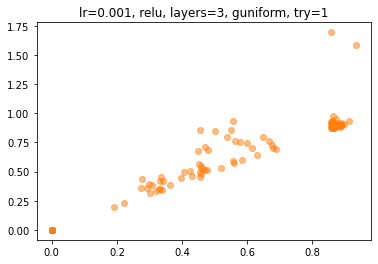

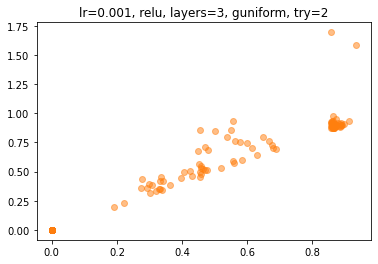

lr=0.001, relu, layers=3, guniform
Final Average Loss:  1.3976211547851562
Iteration Execution Time (min) 12.44124235312144


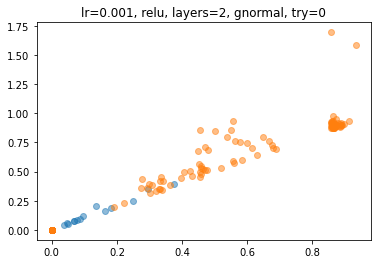

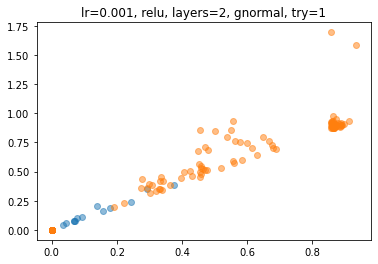

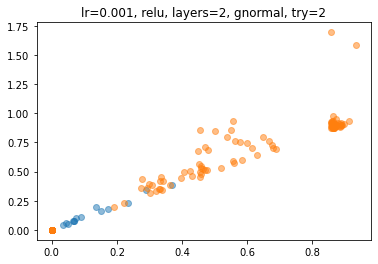

lr=0.001, relu, layers=2, gnormal
Final Average Loss:  1.1395251750946045
Iteration Execution Time (min) 11.889354352156321


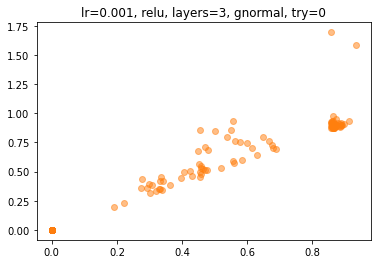

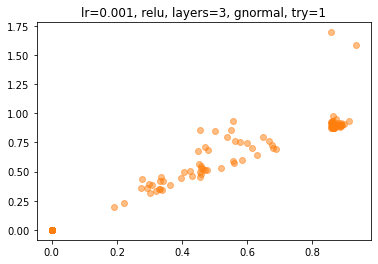

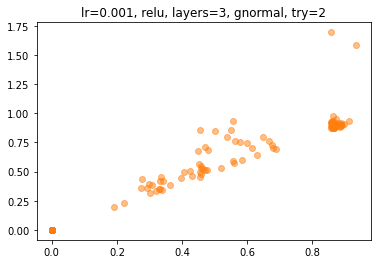

lr=0.001, relu, layers=3, gnormal
Final Average Loss:  1.397621989250183
Iteration Execution Time (min) 11.925349382559459


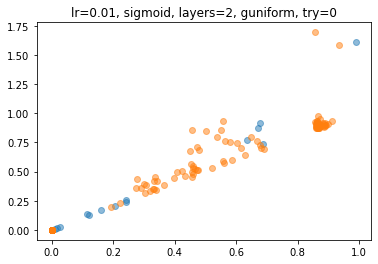

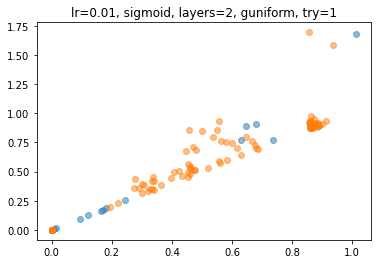

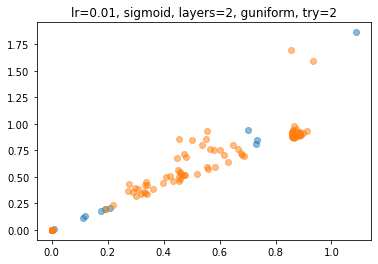

lr=0.01, sigmoid, layers=2, guniform
Final Average Loss:  1.06949782371521
Iteration Execution Time (min) 12.881476700305939


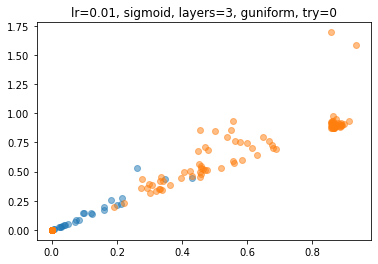

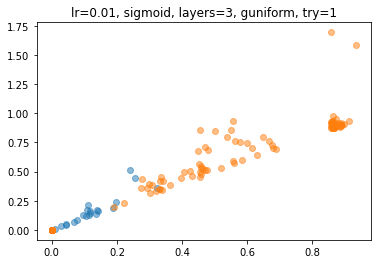

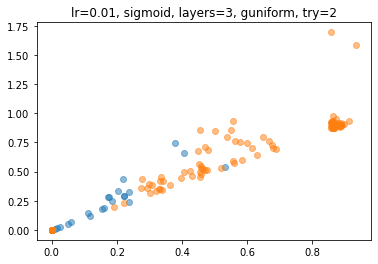

lr=0.01, sigmoid, layers=3, guniform
Final Average Loss:  0.6794251402219137
Iteration Execution Time (min) 23.70087589820226


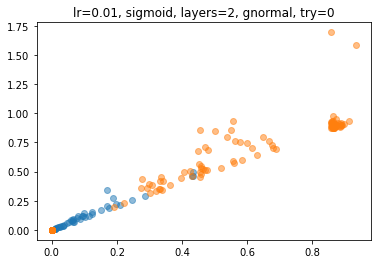

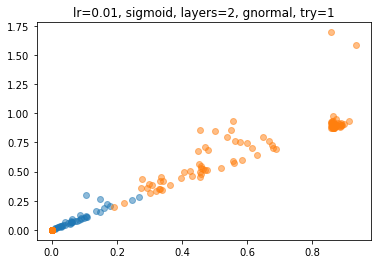

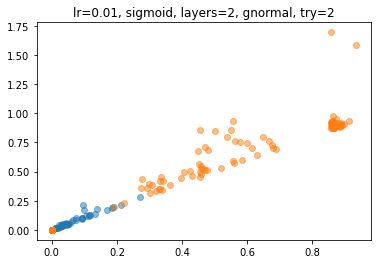

lr=0.01, sigmoid, layers=2, gnormal
Final Average Loss:  0.7779491345087687
Iteration Execution Time (min) 12.099003799756368


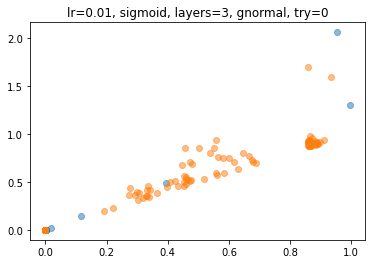

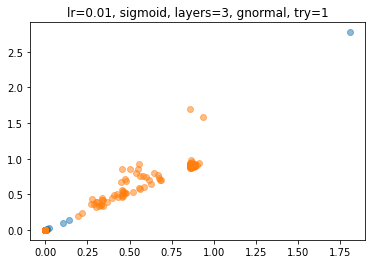

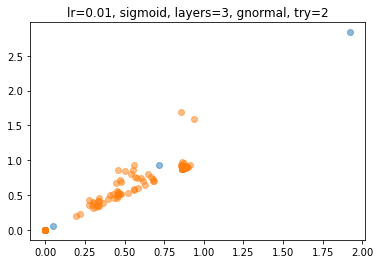

lr=0.01, sigmoid, layers=3, gnormal
Final Average Loss:  1.2372889916102092
Iteration Execution Time (min) 11.932971866925557


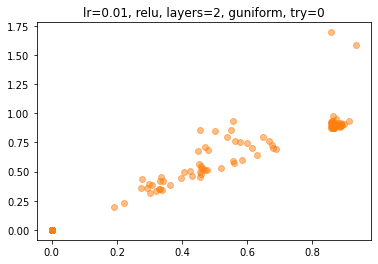

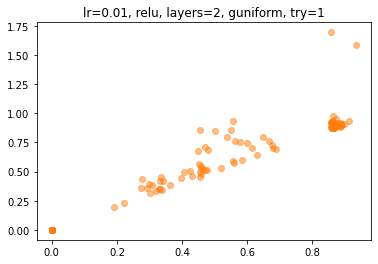

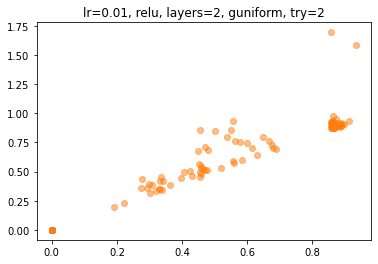

lr=0.01, relu, layers=2, guniform
Final Average Loss:  1.3976215521494548
Iteration Execution Time (min) 11.472788282235463


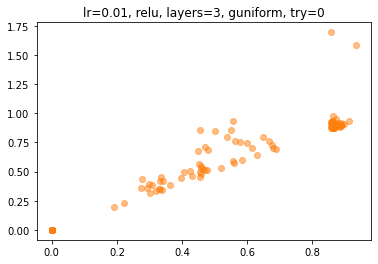

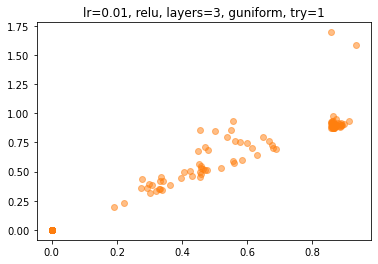

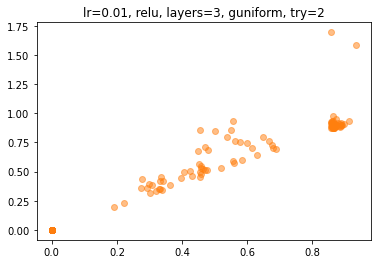

lr=0.01, relu, layers=3, guniform
Final Average Loss:  1.397621472676595
Iteration Execution Time (min) 11.262771232922871


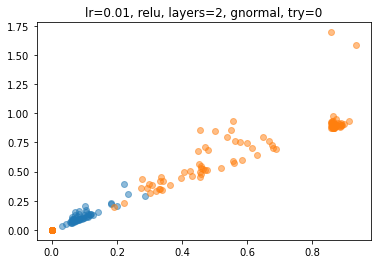

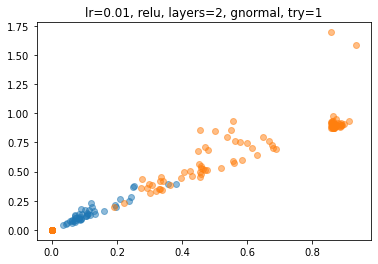

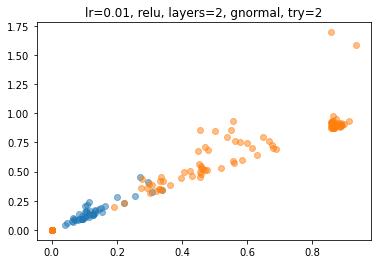

lr=0.01, relu, layers=2, gnormal
Final Average Loss:  0.42566636204719543
Iteration Execution Time (min) 12.234271538257598


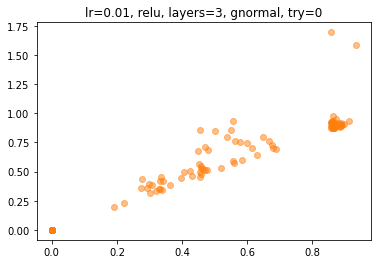

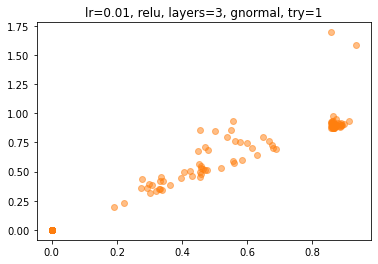

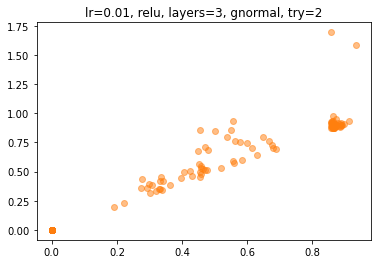

lr=0.01, relu, layers=3, gnormal
Final Average Loss:  1.3976211547851562
Iteration Execution Time (min) 11.536196267604828


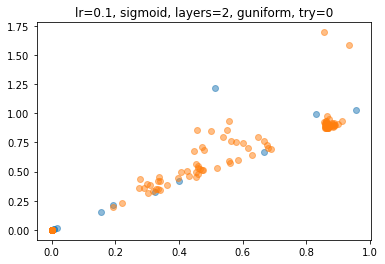

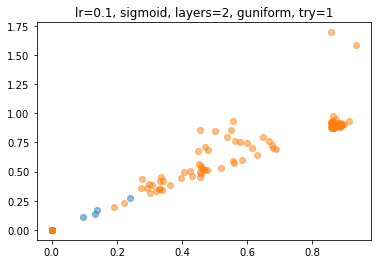

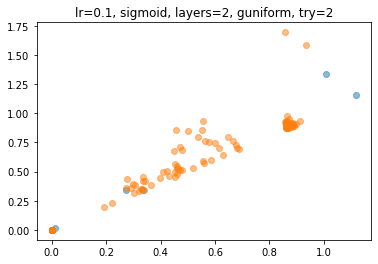

lr=0.1, sigmoid, layers=2, guniform
Final Average Loss:  1.2207868099212646
Iteration Execution Time (min) 11.867345348993938


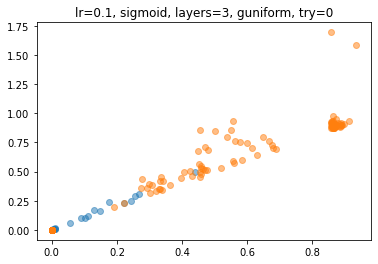

KeyboardInterrupt: 

In [12]:
np.random.seed(1)
swiss = make_swiss_roll_with_hole(n_samples = 300)
swiss = np.array(swiss, dtype = np.float32)
X = swiss

lrs = [0.001,0.01,0.1,0.3]
activations = ["sigmoid","relu"]
layers_list = [2,3]
weights = ["guniform","gnormal"]

n_samples = 300
best_loss_id = ""
best_loss = np.inf
repeat = 3


dictionary={}

start = time.time()
for lr in lrs:
    for activation in activations:
        for weight in weights:
            for layer in layers_list:
                
                loop_start = time.time()
                

                lr_decay = tf.keras.optimizers.schedules.ExponentialDecay(
                                initial_learning_rate=lr,
                                decay_steps=100000,
                                decay_rate=0.96,
                                staircase=True)
            
                if weight== "gnormal": 
                    initializer = initializers.GlorotNormal(seed=1)
                else:
                    initializer = initializers.GlorotUniform(seed=1)

                if layer == 2:
                    model = tf.keras.models.Sequential([
                            tf.keras.layers.Flatten(input_shape=(3, )),
                            tf.keras.layers.Dense(3, activation=activation,kernel_initializer=initializer),
                            tf.keras.layers.Dense(3, activation=activation,kernel_initializer=initializer),
                            tf.keras.layers.Dense(2)
                            ])
                else: 
                    model = tf.keras.models.Sequential([
                            tf.keras.layers.Flatten(input_shape=(3, )),
                            tf.keras.layers.Dense(3, activation=activation,kernel_initializer=initializer),
                            tf.keras.layers.Dense(3, activation=activation,kernel_initializer=initializer),
                            tf.keras.layers.Dense(3, activation=activation,kernel_initializer=initializer),
                            tf.keras.layers.Dense(2)
                            ])

                avg_loss = 0

                for i in range(repeat):
                    
                    combo = "lr={}, {}, layers={}, {}, try={}".format(lr,activation,layer,weight,i)
                
                    model.compile(loss=shift_inv_dist_tune(),optimizer = tf.keras.optimizers.Adam(
                        learning_rate=lr_decay, name='Adam'),run_eagerly=True)
                    history = model.fit(X, X,epochs=50,batch_size=n_samples,verbose=0) 
                    final_loss = history.history["loss"][-1]

                    dictionary[combo] = final_loss
                    
                    if final_loss < best_loss:
                        best_loss_id = combo
                        best_loss = final_loss
                        
                    avg_loss += final_loss
                    

                    PD(scale(model.predict(X)))
                    PD(scale(X))
                    plt.title(combo)
                    plt.show() 
                    
                    
            
                avg_loss = avg_loss/repeat
                print("lr={}, {}, layers={}, {}".format(lr,activation,layer,weight))
                print("Final Average Loss: ", avg_loss)
                
                loop_end = time.time()
                print("Iteration Execution Time (min)",(loop_end-loop_start)/60)

end = time.time()
print("The best parameters: ", best_loss_id)
print("The smallest loss: ", best_loss)
print("Execution Time (hrs): ", (end-start)/3600)

display(dictionary)

In [13]:
dictionary

{'lr=0.001, sigmoid, layers=2, guniform, try=0': 1.1011360883712769,
 'lr=0.001, sigmoid, layers=2, guniform, try=1': 1.0919275283813477,
 'lr=0.001, sigmoid, layers=2, guniform, try=2': 1.0900418758392334,
 'lr=0.001, sigmoid, layers=3, guniform, try=0': 0.9034267067909241,
 'lr=0.001, sigmoid, layers=3, guniform, try=1': 0.8226185441017151,
 'lr=0.001, sigmoid, layers=3, guniform, try=2': 0.7886247038841248,
 'lr=0.001, sigmoid, layers=2, gnormal, try=0': 0.8708864450454712,
 'lr=0.001, sigmoid, layers=2, gnormal, try=1': 0.8815993070602417,
 'lr=0.001, sigmoid, layers=2, gnormal, try=2': 0.7806787490844727,
 'lr=0.001, sigmoid, layers=3, gnormal, try=0': 1.1340895891189575,
 'lr=0.001, sigmoid, layers=3, gnormal, try=1': 1.0709550380706787,
 'lr=0.001, sigmoid, layers=3, gnormal, try=2': 1.0405681133270264,
 'lr=0.001, relu, layers=2, guniform, try=0': 0.6982893347740173,
 'lr=0.001, relu, layers=2, guniform, try=1': 0.6413047313690186,
 'lr=0.001, relu, layers=2, guniform, try=2': 

### Shift Invariant Distance Example (from the internet)

original bottleneck distance 6.385148351220664
dilation-invariant bottleneck distance (using log) is 3.251144030742807


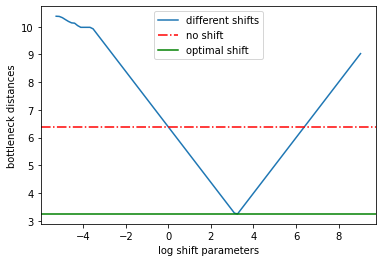

In [9]:
#load data

#file_list = ['activity_net_euclidean_cosine.npz','activity_net_euclidean.npz']
#file_list = ['activity_net_euclidean_expmap_poincare.npz','activity_net_poincare.npz']
file_list = ['mammals_euclidean_cosine.npz','mammals_euclidean.npz']
#file_list = ['mammals_euclidean_expmap_poincare.npz','mammals_poincare.npz']

dist_list = [np.load(u)['arr_0'] for u in file_list]

X = dist_list[0][0]
Y = dist_list[1][0]

X = np.delete(X, -1, axis = 1)
Y = np.delete(Y, -1, axis = 1)

# ## avoid -inf in log map
ep = 1e-10
X = np.log(X+ep)
Y = np.log(Y+ep)

shiftInv, bottleneckDistance, minBottleneckDistance, bestShift = myDistance(X, Y, 100)

plt.figure()
label = ['different shifts','no shift','optimal shift']
plt.xlabel("log shift parameters")
plt.ylabel("bottleneck distances")
plt.plot(shiftInv[0:len(shiftInv)-1], bottleneckDistance[0:len(bottleneckDistance)-1])
# the last element corresponds to no dilation
plt.axhline(y=bottleneckDistance[-1], color='r', linestyle='-.')
plt.axhline(y=minBottleneckDistance, color='g', linestyle='-')
plt.legend(label, loc='best')

## Used Functions (run the whole cell)

In [234]:
def scale(X):
    return (X - tf.math.reduce_mean(X,axis=0))/tf.math.reduce_max(tf.math.reduce_std(X,axis=0))

def PD(X,mel=12):
    X = np.array(X, dtype = np.float32) 
    modelR = RipsModel(P=X,X=X, mel=mel, dim=1, card = 150)
    Xdgm = modelR.call()[0]
    plt.scatter(Xdgm.numpy()[:,0],Xdgm.numpy()[:,1],alpha=0.5)
    return 

def plot(X,dim = 3,deg=45):
    
    if dim==3:
        fig = plt.figure(figsize=plt.figaspect(1))
        ax=fig.add_subplot(projection='3d')
        ax.scatter(X[:,0],X[:,1],X[:,2])
        ax.view_init(0,deg)
        
    return 

def make_swiss_roll_with_hole(n_samples=100, noise=0.0, random_state=None):
    # https://github.com/scikit-learn/scikit-learn/blob/95119c13a/sklearn/datasets/_samples_generator.py#L1401
    generator = check_random_state(random_state)
    t = 1.5 * np.pi * (1 + 2 * generator.rand(1, n_samples))
    x = t * np.cos(t)
    y = 21 * generator.rand(1, n_samples)
    z = t * np.sin(t)

    X = np.concatenate((x, y, z))

    # ranges of three coordinates:
    # np.max(X[2,:]) = 14.136094274051034
    # np.min(X[2,:]) = -11.040707948365629
    # np.max(X[1,:]) = 20.996180119068676
    # np.min(X[1,:]) = 0.004955591716158225
    # np.max(X[0,:]) = 12.60593128332993
    # np.min(X[0,:]) = -9.47727415039662

    # mask = ((X[0, :]>-8) & (X[0, :]<0) & (X[2, :]>-4) & (X[2, :]<7) & (X[1, :]>5) & (X[1, :]<15))
    # mask = ((X[0, :]>-10) & (X[0, :]<0) & (X[2, :]>-4) & (X[2, :]<7) & (X[1, :]>5) & (X[1, :]<15))
    mask = ((X[0, :]>-10) & (X[0, :]<-5) & (X[2, :]>-4) & (X[2, :]<7) & (X[1, :]>5) & (X[1, :]<15))
    X[:, mask] = None
    
    X += noise * generator.randn(3, n_samples)
    X = X.T
    t = np.squeeze(t)

    # remove the nan values (related to hole):
    hole_point_indices_3D = np.isnan(X)
    hole_point_indices = np.asarray([(hole_point_indices_3D[i, 0] | hole_point_indices_3D[i, 1] | hole_point_indices_3D[i, 2]) for i in range(hole_point_indices_3D.shape[0])])
    t = t[~hole_point_indices]
    X = X[~hole_point_indices]

    return X

In [34]:
def normalize(X):
    return (X - tf.math.reduce_mean(X,axis=0))/tf.math.reduce_std(X,axis=0)

In [3]:
#this function is for the shift-invariant example from the internet

def myDistance(X, Y, num_partitions):
    

    ## character point
    indX = np.argmax(X[:,1]-X[:,0])
    indY = np.argmax(Y[:,1]-Y[:,0])
    chaX = X[indX,:]
    chaY = Y[indY,:]
    
    ## define the searching interval
    B = 1e3 ## translation parameter. This is a bug in gudhi that they donot accept negative inputs
    oriDist = gd.bottleneck_distance(X+B,Y+B)
#    print("original bottleneck distance", oriDist)
    upBound = max(Y[:,1])-chaX[1]+oriDist
    lowBound = chaY[1]-max(X[:,1])-oriDist
    
    ## define shifts
    shifts = np.linspace(lowBound, upBound, num_partitions)
    shiftInv = np.append(shifts, 0)
    bottleneckDistance = []
    
    ## compute bottleneck distance
    for shift in shiftInv:
        shiftX = shift+X
        dist = gd.bottleneck_distance(shiftX+B, Y+B)
        bottleneckDistance.append(dist)

    minBottleneckDistance = min(bottleneckDistance)
    bestShift = shiftInv[np.array(bottleneckDistance).argmin()]
    bestShift = bestShift.item()

#    print("dilation-invariant bottleneck distance (using log) is", minBottleneckDistance)
    
    return shiftInv, bottleneckDistance, minBottleneckDistance, bestShift



In [ ]:
class shift_inv_dist_tune(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, X, Y):

        
        X = scale(X)
        Y = scale(Y)
        
        
        modelR = RipsModel(P=Y, X=X, mel=12, dim=1, card = 150)
        
        

        #Compute persistence diagram
        Zdgm = modelR.call()[1]
        Y_pd = Zdgm 

        Xdgm = modelR.call()[0]
        X_pd = Xdgm 

        
        #shifting the data so its >=0 so we can take the log 

        X_pd += 0.1 #tf.math.abs(tf.math.reduce_min(X_pd)) #ASK PROFS ABOUT THIS 0.1 shift okay?
        Y_pd += 0.1 #tf.math.abs(tf.math.reduce_min(Y_pd)) 

        X_pd = tf.math.log(X_pd) 
        Y_pd = tf.math.log(Y_pd)
        
        #check for issues with numpy vs tensorflow            
        shiftInv, bottleneckDistance, minBottleneckDistance, bestShift = myDistance(Y_pd, X_pd, 100)
        
        
        #best shift
        shiftedY = Y_pd + bestShift 
        

        # Loss is Wasserstein distance
        loss = tf.square(wasserstein_distance(shiftedY, X_pd, order=2, internal_p=2, enable_autodiff=True))
        
        return loss